<a href="https://colab.research.google.com/github/AdrienVansuyt/Python-Quant-Exercices/blob/main/BTC_SINGLE_PRINT_BOT_10K_TO_1M_2YEARS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Single print signals on BTC**

[*********************100%%**********************]  1 of 1 completed


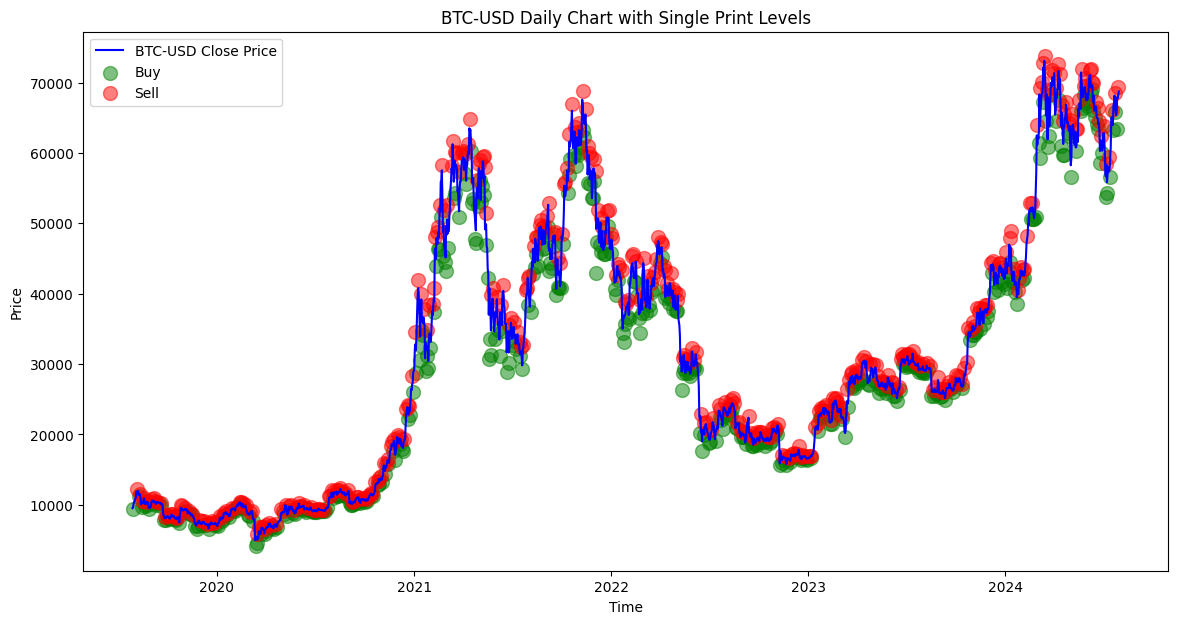

[*********************100%%**********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BTC-USD']: YFChartError('%ticker%: Invalid input - interval=3d is not supported. Valid intervals: , 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]')
[*********************100%%**********************]  1 of 1 completed


No data available for BTC-USD with interval 3d


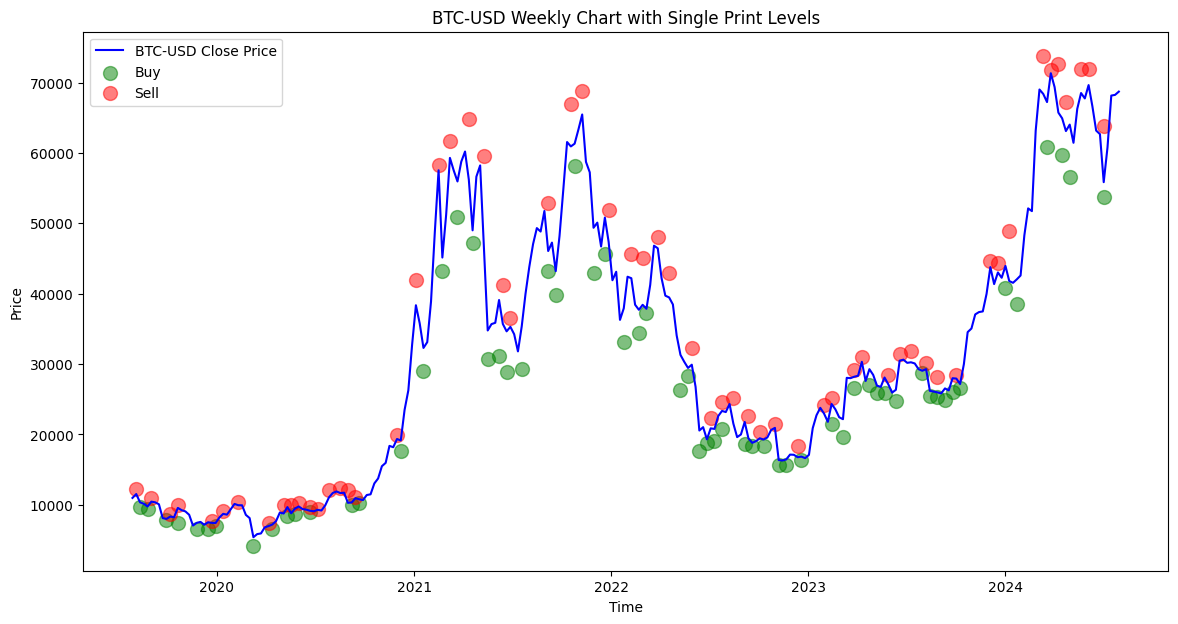

[*********************100%%**********************]  1 of 1 completed


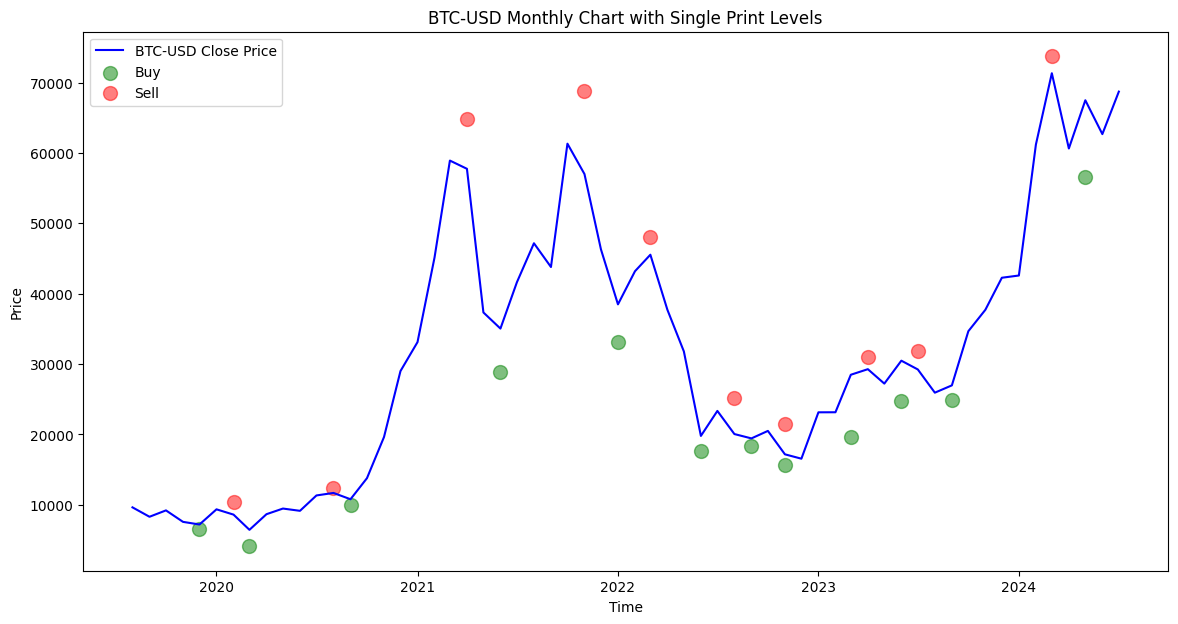

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Définir les unités de temps
timeframes = {
    'Daily': '1d',
    '3 Days': '3d',
    'Weekly': '1wk',
    'Monthly': '1mo'
}

# Fonction pour détecter les niveaux de single print
def detect_single_print_levels(data):
    single_print_levels = {'buy': [], 'sell': []}
    for i in range(1, len(data)-1):
        if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1]:
            single_print_levels['buy'].append((data.index[i], data['Low'][i]))
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_print_levels['sell'].append((data.index[i], data['High'][i]))
    return single_print_levels

# Télécharger les données du BTC et détecter les niveaux de single print pour chaque unité de temps
btc_ticker = 'BTC-USD'

for label, tf in timeframes.items():
    data = yf.download(btc_ticker, period='5y', interval=tf)  # Télécharger les données des 5 dernières années
    if not data.empty:
        single_print_levels = detect_single_print_levels(data)

        # Tracer le graphique
        plt.figure(figsize=(14, 7))
        plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

        # Ajouter les niveaux de single print
        for level in single_print_levels['buy']:
            plt.scatter(level[0], level[1], color='green', s=100, alpha=0.5, label='Buy' if level == single_print_levels['buy'][0] else "")
        for level in single_print_levels['sell']:
            plt.scatter(level[0], level[1], color='red', s=100, alpha=0.5, label='Sell' if level == single_print_levels['sell'][0] else "")

        plt.title(f'BTC-USD {label} Chart with Single Print Levels')
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.legend()
        plt.show()
    else:
        print(f"No data available for {btc_ticker} with interval {tf}")


In [3]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=6deff0d82ea9df1d4024077d4bc10094ed7afe8b48096fb3c4cd2ae6a109dcdb
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


[*********************100%%**********************]  1 of 1 completed


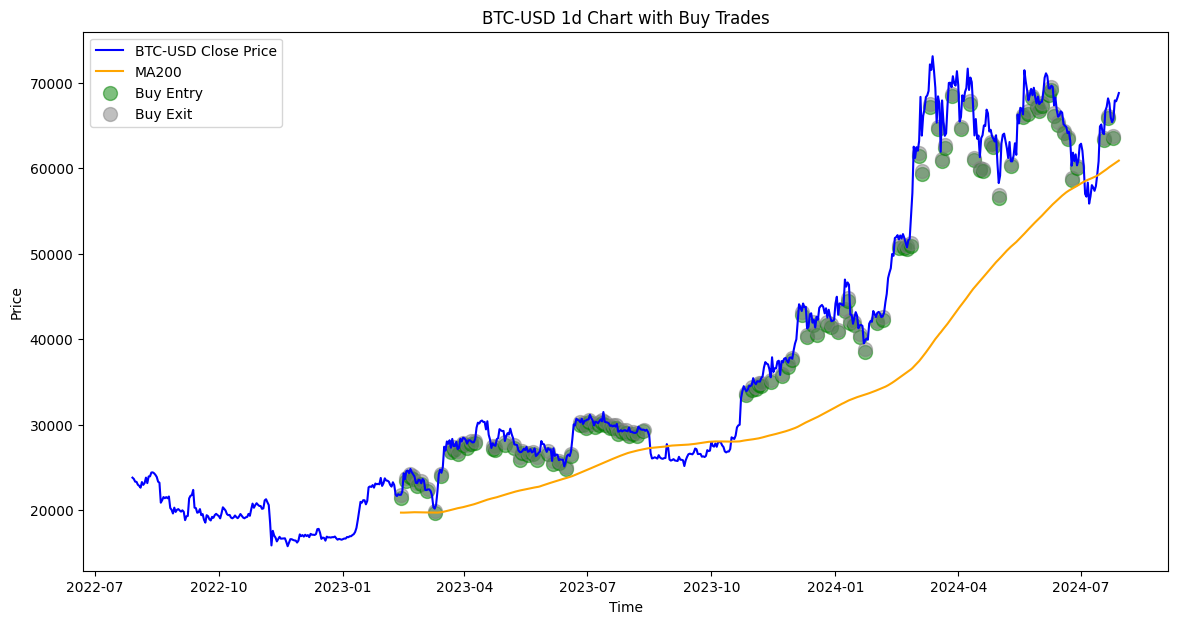

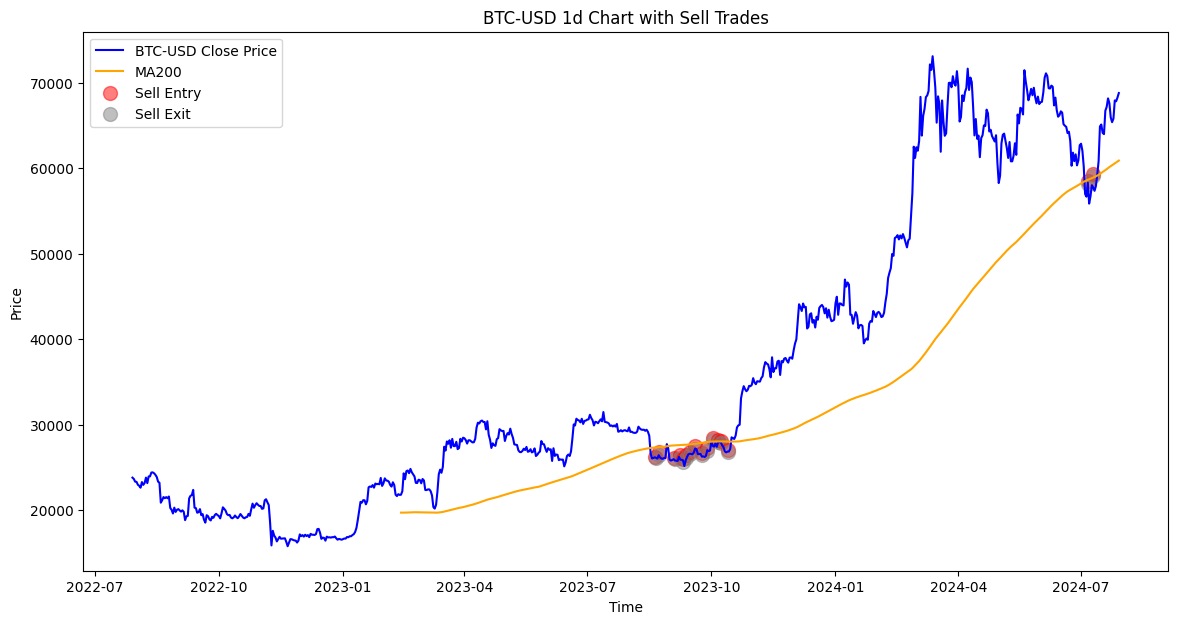

PnL for Buy Trades:
       PnL
0    300.0
1    300.0
2    300.0
3    300.0
4    300.0
..     ...
104  300.0
105  300.0
106  300.0
107  300.0
108  300.0

[109 rows x 1 columns]
Total PnL for Buy Trades: 32514.255859375

PnL for Sell Trades:
           PnL
0   106.367188
1   300.000000
2   120.117188
3   300.000000
4   300.000000
5   300.000000
6   300.000000
7   300.000000
8   300.000000
9   300.000000
10  300.000000
11  300.000000
12  300.000000
13  300.000000
14  300.000000
15  300.000000
Total PnL for Sell Trades: 4426.484375

Total PnL for All Trades:
       PnL
0    300.0
1    300.0
2    300.0
3    300.0
4    300.0
..     ...
120  300.0
121  300.0
122  300.0
123  300.0
124  300.0

[125 rows x 1 columns]
Total PnL: 36940.740234375


In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Liste des unités de temps (ordonnée du plus petit au plus grand)
timeframes = ['1d']
period = '2y'
sl_pips = 150
tp_pips = 300
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Calculer les moyennes mobiles pour déterminer la tendance primaire
data['MA200'] = data['Close'].rolling(window=200).mean()

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'buy': [], 'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints haussiers (niveau de support) et tendance haussière
        if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1] and data['Close'][i] > data['MA200'][i]:
            single_prints['buy'].append((data.index[i], data['Low'][i]))

        # Vérifier les single prints baissiers (niveau de résistance) et tendance baissière
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1] and data['Close'][i] < data['MA200'][i]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold):
    trades = {'buy': [], 'sell': []}

    for sp in single_prints['buy']:
        entry_date, entry_price = sp
        sl_price = entry_price - sl_pips
        tp_price = entry_price + tp_pips
        highest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['Low'][i] <= sl_price:
                trades['buy'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', sl_price - entry_price))
                break
            if data['High'][i] >= tp_price:
                trades['buy'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', tp_price - entry_price))
                break

            # Mise à jour du trailing stop
            if data['High'][i] > highest_price:
                highest_price = data['High'][i]
                if highest_price - entry_price > trailing_threshold:
                    sl_price = highest_price - sl_pips

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', entry_price - sl_price))
                break
            if data['Low'][i] <= tp_price:
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', entry_price - tp_price))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold)

# Afficher les trades et les graphiques
def plot_trades(data, trades, trade_type):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')
    plt.plot(data['MA200'], label='MA200', color='orange')

    if trade_type == 'buy':
        color = 'green'
        label = 'Buy'
    else:
        color = 'red'
        label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

for trade_type in ['buy', 'sell']:
    plot_trades(data, trades, trade_type)

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl_buy = [trade[-1] for trade in trades['buy']]
    pnl_sell = [trade[-1] for trade in trades['sell']]
    total_pnl = pnl_buy + pnl_sell
    return pnl_buy, pnl_sell, total_pnl

pnl_buy, pnl_sell, total_pnl = calculate_pnl(trades)

pnl_df_buy = pd.DataFrame({'PnL': pnl_buy})
pnl_df_sell = pd.DataFrame({'PnL': pnl_sell})
pnl_df_total = pd.DataFrame({'PnL': total_pnl})

print('PnL for Buy Trades:')
print(pnl_df_buy)
print('Total PnL for Buy Trades:', pnl_df_buy['PnL'].sum())

print('\nPnL for Sell Trades:')
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())

print('\nTotal PnL for All Trades:')
print(pnl_df_total)
print('Total PnL:', pnl_df_total['PnL'].sum())


# **Ce script va maintenant :**

- Détecter les single prints vierges.
- Appliquer les stop-loss, take-profit et trailing stop.
- Afficher les trades sur les graphiques.
- Calculer et afficher la PnL pour les trades "buy" et "sell".
- Calculer et afficher le pourcentage de réussite (winrate) pour les trades "buy" et "sell".
- Afficher la PnL totale et le winrate total pour tous les trades.

[*********************100%%**********************]  1 of 1 completed


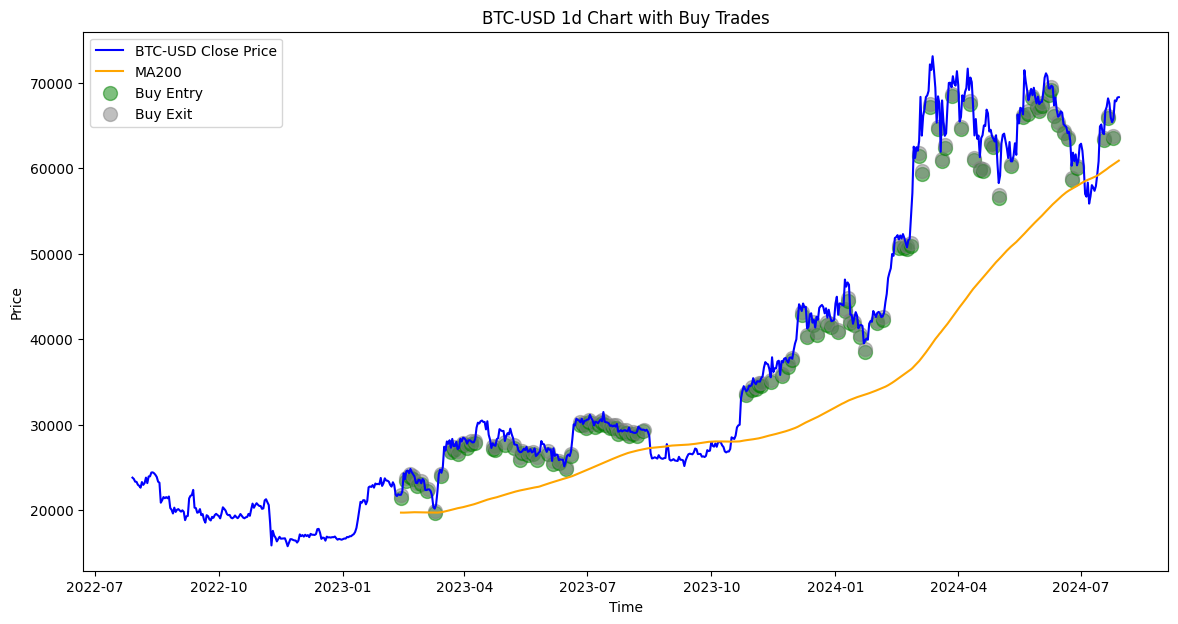

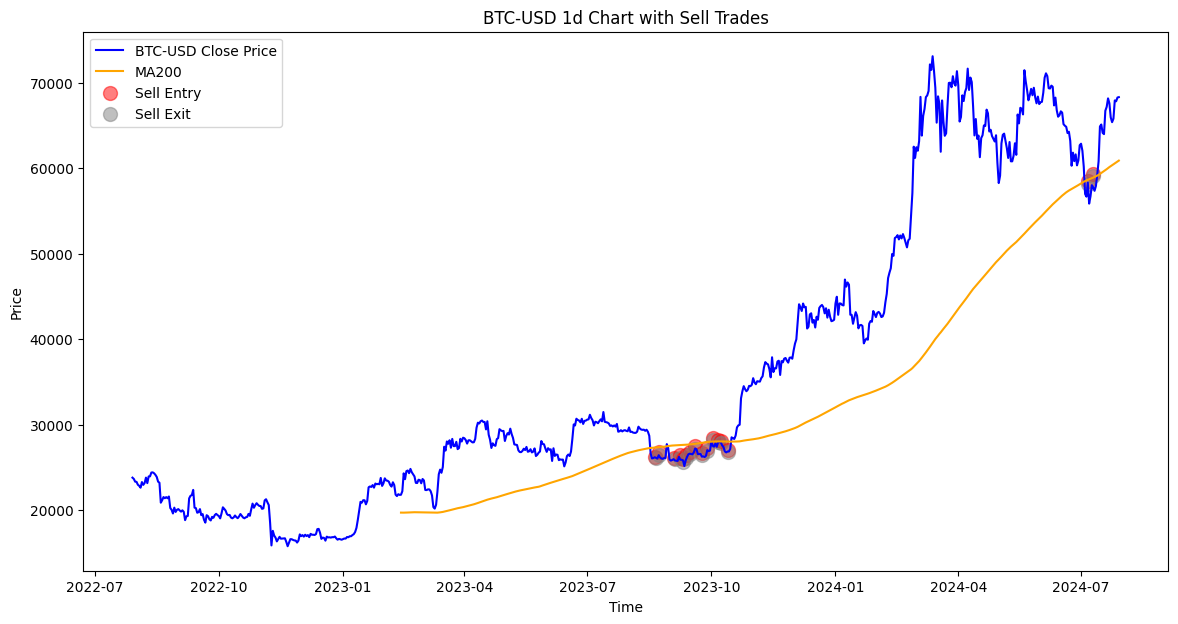

PnL for Buy Trades:
       PnL
0    300.0
1    300.0
2    300.0
3    300.0
4    300.0
..     ...
104  300.0
105  300.0
106  300.0
107  300.0
108  300.0

[109 rows x 1 columns]
Total PnL for Buy Trades: 32514.255859375
Winrate for Buy Trades: 100.00%

PnL for Sell Trades:
           PnL
0   106.367188
1   300.000000
2   120.117188
3   300.000000
4   300.000000
5   300.000000
6   300.000000
7   300.000000
8   300.000000
9   300.000000
10  300.000000
11  300.000000
12  300.000000
13  300.000000
14  300.000000
15  300.000000
Total PnL for Sell Trades: 4426.484375
Winrate for Sell Trades: 100.00%

Total PnL for All Trades:
       PnL
0    300.0
1    300.0
2    300.0
3    300.0
4    300.0
..     ...
120  300.0
121  300.0
122  300.0
123  300.0
124  300.0

[125 rows x 1 columns]
Total PnL: 36940.740234375
Total Winrate: 100.00%


In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Liste des unités de temps (ordonnée du plus petit au plus grand)
timeframes = ['1d']
period = '2y'
sl_pips = 150
tp_pips = 300
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Calculer les moyennes mobiles pour déterminer la tendance primaire
data['MA200'] = data['Close'].rolling(window=200).mean()

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'buy': [], 'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints haussiers (niveau de support) et tendance haussière
        if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1] and data['Close'][i] > data['MA200'][i]:
            single_prints['buy'].append((data.index[i], data['Low'][i]))

        # Vérifier les single prints baissiers (niveau de résistance) et tendance baissière
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1] and data['Close'][i] < data['MA200'][i]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold):
    trades = {'buy': [], 'sell': []}

    for sp in single_prints['buy']:
        entry_date, entry_price = sp
        sl_price = entry_price - sl_pips
        tp_price = entry_price + tp_pips
        highest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['Low'][i] <= sl_price:
                trades['buy'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', sl_price - entry_price))
                break
            if data['High'][i] >= tp_price:
                trades['buy'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', tp_price - entry_price))
                break

            # Mise à jour du trailing stop
            if data['High'][i] > highest_price:
                highest_price = data['High'][i]
                if highest_price - entry_price > trailing_threshold:
                    sl_price = highest_price - sl_pips

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', entry_price - sl_price))
                break
            if data['Low'][i] <= tp_price:
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', entry_price - tp_price))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold)

# Afficher les trades et les graphiques
def plot_trades(data, trades, trade_type):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')
    plt.plot(data['MA200'], label='MA200', color='orange')

    if trade_type == 'buy':
        color = 'green'
        label = 'Buy'
    else:
        color = 'red'
        label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

for trade_type in ['buy', 'sell']:
    plot_trades(data, trades, trade_type)

# Calculer et afficher la PnL et le winrate
def calculate_pnl_and_winrate(trades):
    pnl_buy = [trade[-1] for trade in trades['buy']]
    pnl_sell = [trade[-1] for trade in trades['sell']]
    total_pnl = pnl_buy + pnl_sell

    win_buy = sum(p > 0 for p in pnl_buy)
    win_sell = sum(p > 0 for p in pnl_sell)
    total_win = win_buy + win_sell

    winrate_buy = win_buy / len(pnl_buy) * 100 if pnl_buy else 0
    winrate_sell = win_sell / len(pnl_sell) * 100 if pnl_sell else 0
    total_winrate = total_win / len(total_pnl) * 100 if total_pnl else 0

    return pnl_buy, pnl_sell, total_pnl, winrate_buy, winrate_sell, total_winrate

pnl_buy, pnl_sell, total_pnl, winrate_buy, winrate_sell, total_winrate = calculate_pnl_and_winrate(trades)

pnl_df_buy = pd.DataFrame({'PnL': pnl_buy})
pnl_df_sell = pd.DataFrame({'PnL': pnl_sell})
pnl_df_total = pd.DataFrame({'PnL': total_pnl})

print('PnL for Buy Trades:')
print(pnl_df_buy)
print('Total PnL for Buy Trades:', pnl_df_buy['PnL'].sum())
print('Winrate for Buy Trades: {:.2f}%'.format(winrate_buy))

print('\nPnL for Sell Trades:')
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format(winrate_sell))

print('\nTotal PnL for All Trades:')
print(pnl_df_total)
print('Total PnL:', pnl_df_total['PnL'].sum())
print('Total Winrate: {:.2f}%'.format(total_winrate))


Maintenant, prenons 10.000$ avec un risque de 5% par trade

[*********************100%%**********************]  1 of 1 completed


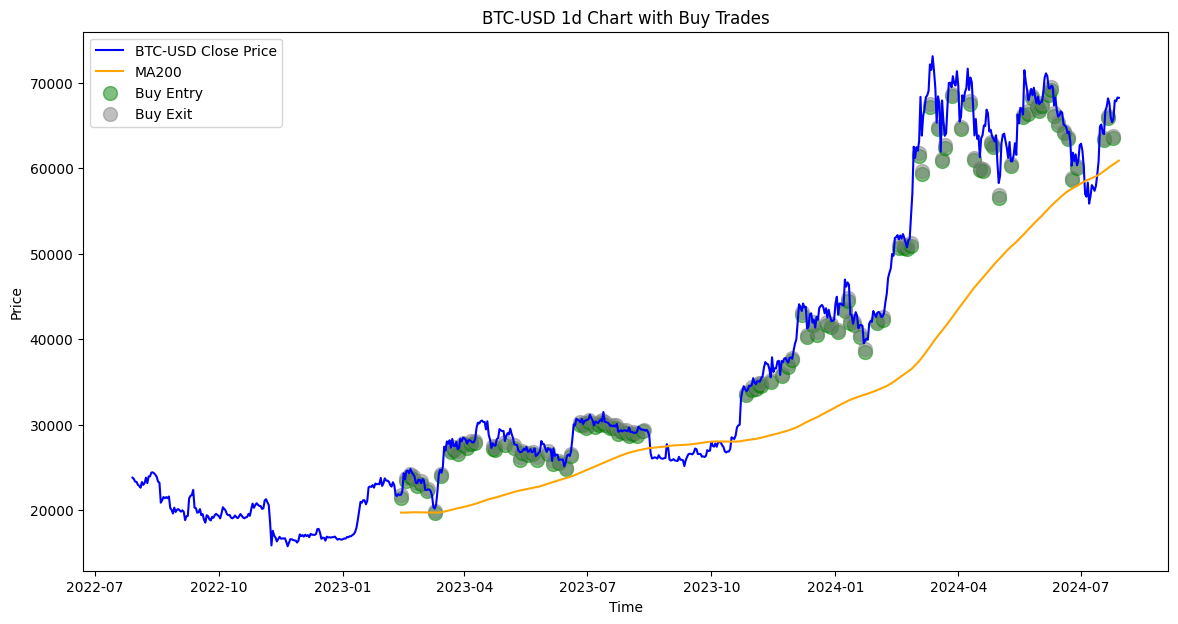

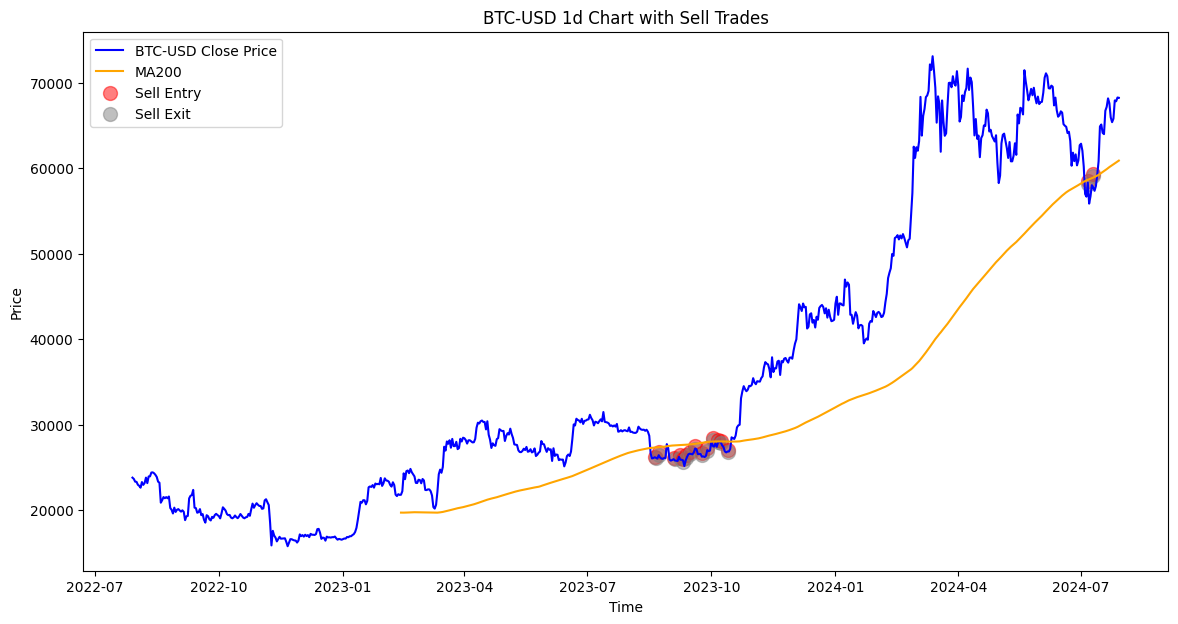

PnL for Buy Trades:
          PnL
0    100000.0
1    100000.0
2    100000.0
3    100000.0
4    100000.0
..        ...
104  100000.0
105  100000.0
106  100000.0
107  100000.0
108  100000.0

[109 rows x 1 columns]
Total PnL for Buy Trades: 10838085.286458334
Winrate for Buy Trades: 100.00%

PnL for Sell Trades:
              PnL
0    35455.729167
1   100000.000000
2    40039.062500
3   100000.000000
4   100000.000000
5   100000.000000
6   100000.000000
7   100000.000000
8   100000.000000
9   100000.000000
10  100000.000000
11  100000.000000
12  100000.000000
13  100000.000000
14  100000.000000
15  100000.000000
Total PnL for Sell Trades: 1475494.7916666665
Winrate for Sell Trades: 100.00%

Total PnL for All Trades:
          PnL
0    100000.0
1    100000.0
2    100000.0
3    100000.0
4    100000.0
..        ...
120  100000.0
121  100000.0
122  100000.0
123  100000.0
124  100000.0

[125 rows x 1 columns]
Total PnL: 12313580.078125
Total Winrate: 100.00%


In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Liste des unités de temps (ordonnée du plus petit au plus grand)
timeframes = ['1d']
period = '2y'
sl_pips = 150
tp_pips = 300
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Paramètres de gestion de risque
capital = 10000
risk_per_trade = 500
min_contract_size = 0.5

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Calculer les moyennes mobiles pour déterminer la tendance primaire
data['MA200'] = data['Close'].rolling(window=200).mean()

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'buy': [], 'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints haussiers (niveau de support) et tendance haussière
        if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1] and data['Close'][i] > data['MA200'][i]:
            single_prints['buy'].append((data.index[i], data['Low'][i]))

        # Vérifier les single prints baissiers (niveau de résistance) et tendance baissière
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1] and data['Close'][i] < data['MA200'][i]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour calculer la taille de la position
def calculate_position_size(risk_per_trade, sl_pips, pip_value):
    return max(min_contract_size, risk_per_trade / (sl_pips * pip_value))

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, pip_value):
    trades = {'buy': [], 'sell': []}

    for sp in single_prints['buy']:
        entry_date, entry_price = sp
        position_size = calculate_position_size(risk_per_trade, sl_pips, pip_value)
        sl_price = entry_price - sl_pips
        tp_price = entry_price + tp_pips
        highest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['Low'][i] <= sl_price:
                pnl = position_size * (sl_price - entry_price)
                trades['buy'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl))
                break
            if data['High'][i] >= tp_price:
                pnl = position_size * (tp_price - entry_price)
                trades['buy'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl))
                break

            # Mise à jour du trailing stop
            if data['High'][i] > highest_price:
                highest_price = data['High'][i]
                if highest_price - entry_price > trailing_threshold:
                    sl_price = highest_price - sl_pips

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        position_size = calculate_position_size(risk_per_trade, sl_pips, pip_value)
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = position_size * (entry_price - sl_price)
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * (entry_price - tp_price)
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Déterminer la valeur d'un pip pour BTC-USD (en général, 1 pip = 0.01 USD)
pip_value = 0.01

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, pip_value)

# Afficher les trades et les graphiques
def plot_trades(data, trades, trade_type):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')
    plt.plot(data['MA200'], label='MA200', color='orange')

    if trade_type == 'buy':
        color = 'green'
        label = 'Buy'
    else:
        color = 'red'
        label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

for trade_type in ['buy', 'sell']:
    plot_trades(data, trades, trade_type)

# Calculer et afficher la PnL et le winrate
def calculate_pnl_and_winrate(trades):
    pnl_buy = [trade[-1] for trade in trades['buy']]
    pnl_sell = [trade[-1] for trade in trades['sell']]
    total_pnl = pnl_buy + pnl_sell

    win_buy = sum(p > 0 for p in pnl_buy)
    win_sell = sum(p > 0 for p in pnl_sell)
    total_win = win_buy + win_sell

    winrate_buy = win_buy / len(pnl_buy) * 100 if pnl_buy else 0
    winrate_sell = win_sell / len(pnl_sell) * 100 if pnl_sell else 0
    total_winrate = total_win / len(total_pnl) * 100 if total_pnl else 0

    return pnl_buy, pnl_sell, total_pnl, winrate_buy, winrate_sell, total_winrate

pnl_buy, pnl_sell, total_pnl, winrate_buy, winrate_sell, total_winrate = calculate_pnl_and_winrate(trades)

pnl_df_buy = pd.DataFrame({'PnL': pnl_buy})
pnl_df_sell = pd.DataFrame({'PnL': pnl_sell})
pnl_df_total = pd.DataFrame({'PnL': total_pnl})

print('PnL for Buy Trades:')
print(pnl_df_buy)
print('Total PnL for Buy Trades:', pnl_df_buy['PnL'].sum())
print('Winrate for Buy Trades: {:.2f}%'.format(winrate_buy))

print('\nPnL for Sell Trades:')
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format(winrate_sell))

print('\nTotal PnL for All Trades:')
print(pnl_df_total)
print('Total PnL:', pnl_df_total['PnL'].sum())
print('Total Winrate: {:.2f}%'.format(total_winrate))


500 pips de TP

[*********************100%%**********************]  1 of 1 completed


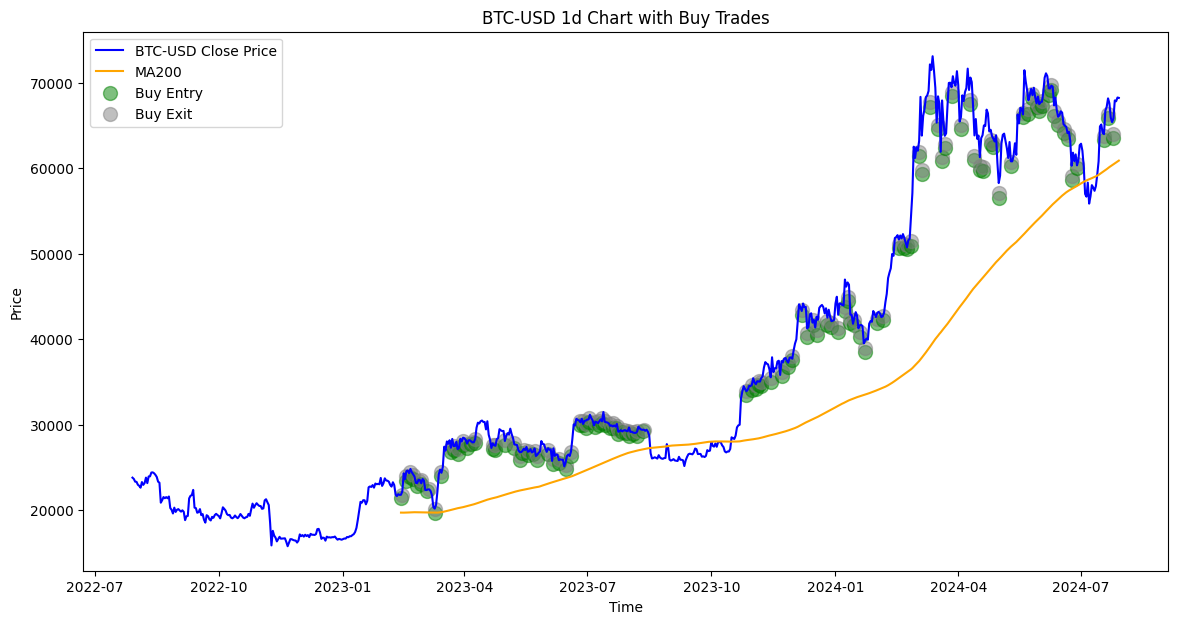

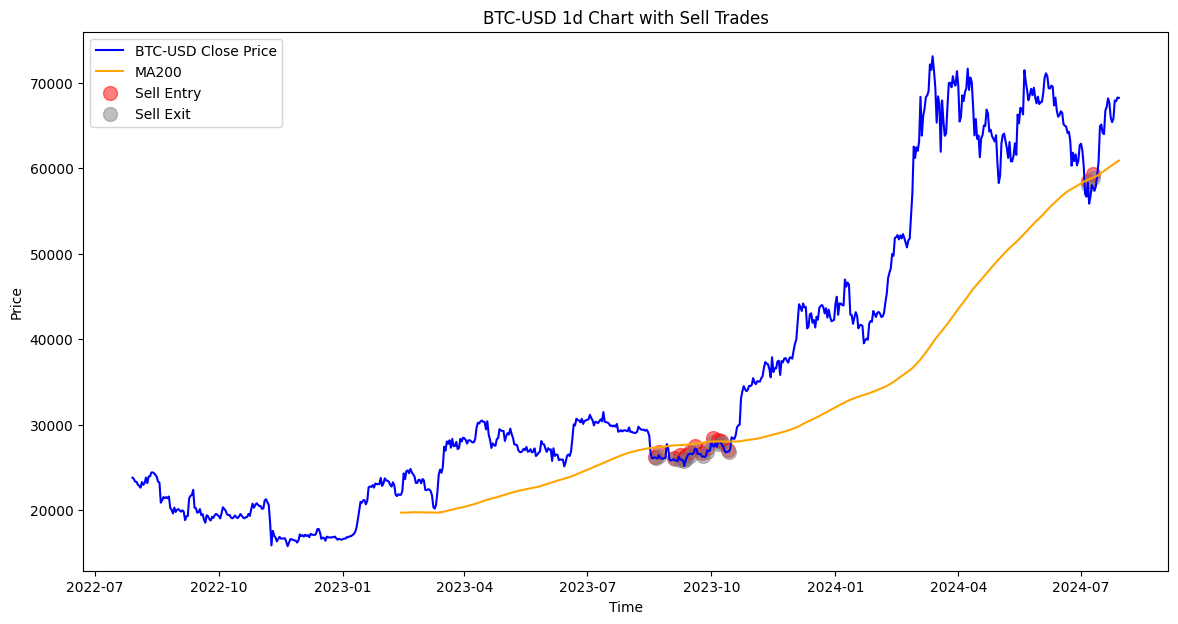

PnL for Buy Trades:
               PnL
0     96108.723958
1    166666.666667
2    166666.666667
3    166666.666667
4    166666.666667
..             ...
104  166666.666667
105  166666.666667
106  166666.666667
107  166666.666667
108  166666.666667

[109 rows x 1 columns]
Total PnL for Buy Trades: 17377350.91145834
Winrate for Buy Trades: 100.00%

PnL for Sell Trades:
              PnL
0    35455.729167
1   166666.666667
2    40039.062500
3   166666.666667
4    62623.046875
5   166666.666667
6   166666.666667
7   166666.666667
8   115002.604167
9   166666.666667
10  166666.666667
11  166666.666667
12   70502.604167
13   85458.333333
14  166666.666667
15  166666.666667
Total PnL for Sell Trades: 2075748.046875
Winrate for Sell Trades: 100.00%

Total PnL for All Trades:
               PnL
0     96108.723958
1    166666.666667
2    166666.666667
3    166666.666667
4    166666.666667
..             ...
120  166666.666667
121   70502.604167
122   85458.333333
123  166666.666667
124  166666.6

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Liste des unités de temps (ordonnée du plus petit au plus grand)
timeframes = ['1d']
period = '2y'
sl_pips = 150
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Paramètres de gestion de risque
capital = 10000
risk_per_trade = 500
min_contract_size = 0.5

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Calculer les moyennes mobiles pour déterminer la tendance primaire
data['MA200'] = data['Close'].rolling(window=200).mean()

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'buy': [], 'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints haussiers (niveau de support) et tendance haussière
        if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1] and data['Close'][i] > data['MA200'][i]:
            single_prints['buy'].append((data.index[i], data['Low'][i]))

        # Vérifier les single prints baissiers (niveau de résistance) et tendance baissière
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1] and data['Close'][i] < data['MA200'][i]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour calculer la taille de la position
def calculate_position_size(risk_per_trade, sl_pips, pip_value):
    return max(min_contract_size, risk_per_trade / (sl_pips * pip_value))

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, pip_value):
    trades = {'buy': [], 'sell': []}

    for sp in single_prints['buy']:
        entry_date, entry_price = sp
        position_size = calculate_position_size(risk_per_trade, sl_pips, pip_value)
        sl_price = entry_price - sl_pips
        tp_price = entry_price + tp_pips
        highest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['Low'][i] <= sl_price:
                pnl = position_size * (sl_price - entry_price)
                trades['buy'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl))
                break
            if data['High'][i] >= tp_price:
                pnl = position_size * (tp_price - entry_price)
                trades['buy'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl))
                break

            # Mise à jour du trailing stop
            if data['High'][i] > highest_price:
                highest_price = data['High'][i]
                if highest_price - entry_price > trailing_threshold:
                    sl_price = highest_price - sl_pips

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        position_size = calculate_position_size(risk_per_trade, sl_pips, pip_value)
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = position_size * (entry_price - sl_price)
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * (entry_price - tp_price)
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Déterminer la valeur d'un pip pour BTC-USD (en général, 1 pip = 0.01 USD)
pip_value = 0.01

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, pip_value)

# Afficher les trades et les graphiques
def plot_trades(data, trades, trade_type):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')
    plt.plot(data['MA200'], label='MA200', color='orange')

    if trade_type == 'buy':
        color = 'green'
        label = 'Buy'
    else:
        color = 'red'
        label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

for trade_type in ['buy', 'sell']:
    plot_trades(data, trades, trade_type)

# Calculer et afficher la PnL et le winrate
def calculate_pnl_and_winrate(trades):
    pnl_buy = [trade[-1] for trade in trades['buy']]
    pnl_sell = [trade[-1] for trade in trades['sell']]
    total_pnl = pnl_buy + pnl_sell

    win_buy = sum(p > 0 for p in pnl_buy)
    win_sell = sum(p > 0 for p in pnl_sell)
    total_win = win_buy + win_sell

    winrate_buy = win_buy / len(pnl_buy) * 100 if pnl_buy else 0
    winrate_sell = win_sell / len(pnl_sell) * 100 if pnl_sell else 0
    total_winrate = total_win / len(total_pnl) * 100 if total_pnl else 0

    return pnl_buy, pnl_sell, total_pnl, winrate_buy, winrate_sell, total_winrate

pnl_buy, pnl_sell, total_pnl, winrate_buy, winrate_sell, total_winrate = calculate_pnl_and_winrate(trades)

pnl_df_buy = pd.DataFrame({'PnL': pnl_buy})
pnl_df_sell = pd.DataFrame({'PnL': pnl_sell})
pnl_df_total = pd.DataFrame({'PnL': total_pnl})

print('PnL for Buy Trades:')
print(pnl_df_buy)
print('Total PnL for Buy Trades:', pnl_df_buy['PnL'].sum())
print('Winrate for Buy Trades: {:.2f}%'.format(winrate_buy))

print('\nPnL for Sell Trades:')
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format(winrate_sell))

print('\nTotal PnL for All Trades:')
print(pnl_df_total)
print('Total PnL:', pnl_df_total['PnL'].sum())
print('Total Winrate: {:.2f}%'.format(total_winrate))


[*********************100%%**********************]  1 of 1 completed


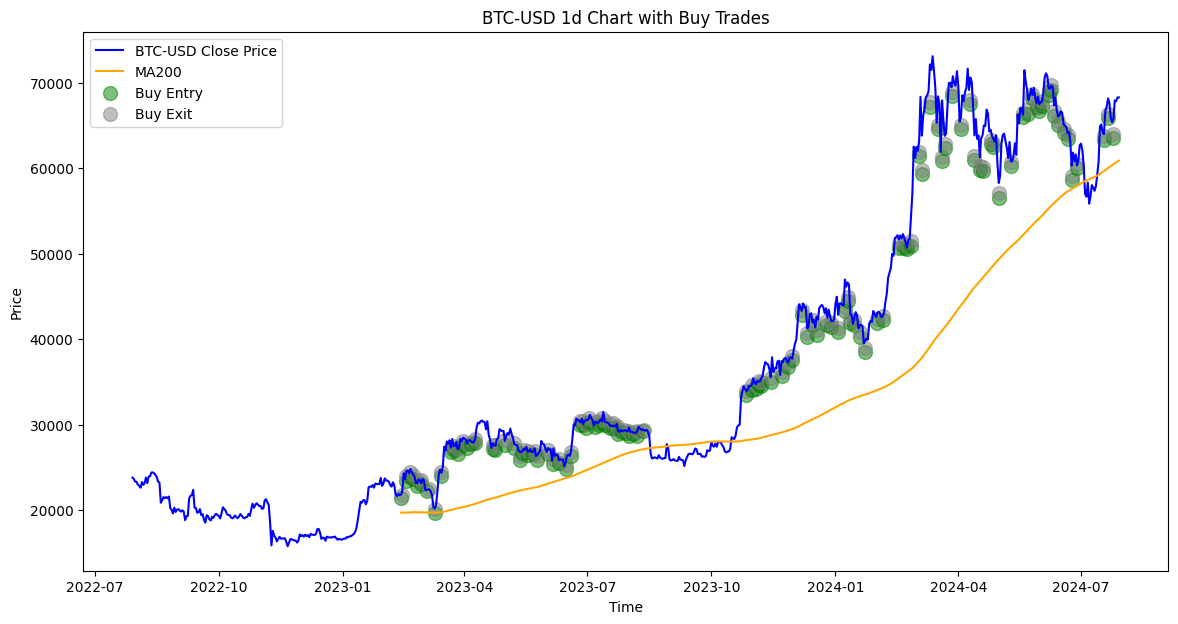

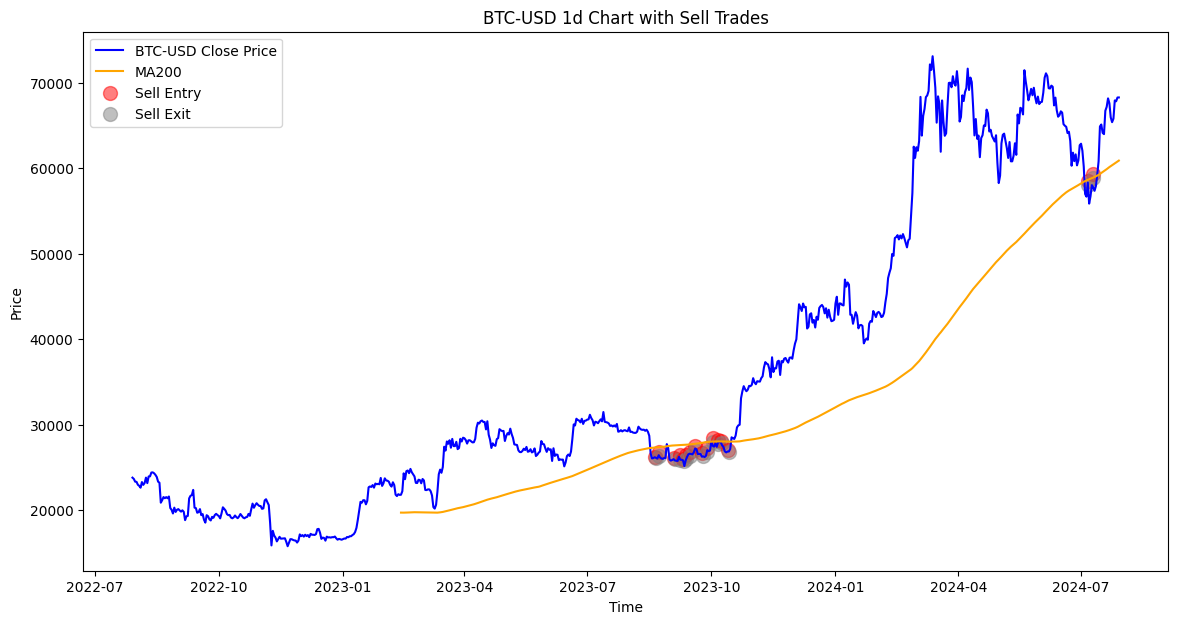

PnL for Buy Trades:
    Entry Date   Entry Price  Exit Date    Exit Price Result            PnL  \
0   2023-02-13  21460.087891 2023-02-14  21748.414062     SL   96108.723958   
1   2023-02-17  23460.755859 2023-02-17  23960.755859     TP  166666.666667   
2   2023-02-20  23927.910156 2023-02-20  24427.910156     TP  166666.666667   
3   2023-02-22  23644.318359 2023-02-22  24144.318359     TP  166666.666667   
4   2023-02-25  22861.558594 2023-02-26  23361.558594     TP  166666.666667   
..         ...           ...        ...           ...    ...            ...   
104 2024-06-24  58601.699219 2024-06-24  59101.699219     TP  166666.666667   
105 2024-06-28  59985.402344 2024-06-28  60485.402344     TP  166666.666667   
106 2024-07-18  63246.164062 2024-07-18  63746.164062     TP  166666.666667   
107 2024-07-21  65842.296875 2024-07-21  66342.296875     TP  166666.666667   
108 2024-07-25  63473.472656 2024-07-25  63973.472656     TP  166666.666667   

     Capital After Trade  Posit

In [10]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Liste des unités de temps (ordonnée du plus petit au plus grand)
timeframes = ['1d']
period = '2y'
sl_pips = 150
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Paramètres de gestion de risque
capital = 10000
risk_per_trade = 500
min_contract_size = 0.5

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Calculer les moyennes mobiles pour déterminer la tendance primaire
data['MA200'] = data['Close'].rolling(window=200).mean()

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'buy': [], 'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints haussiers (niveau de support) et tendance haussière
        if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1] and data['Close'][i] > data['MA200'][i]:
            single_prints['buy'].append((data.index[i], data['Low'][i]))

        # Vérifier les single prints baissiers (niveau de résistance) et tendance baissière
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1] and data['Close'][i] < data['MA200'][i]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour calculer la taille de la position
def calculate_position_size(risk_per_trade, sl_pips, pip_value):
    return max(min_contract_size, risk_per_trade / (sl_pips * pip_value))

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, pip_value):
    trades = {'buy': [], 'sell': []}
    current_capital = capital

    for sp in single_prints['buy']:
        entry_date, entry_price = sp
        position_size = calculate_position_size(risk_per_trade, sl_pips, pip_value)
        sl_price = entry_price - sl_pips
        tp_price = entry_price + tp_pips
        highest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['Low'][i] <= sl_price:
                pnl = position_size * (sl_price - entry_price)
                current_capital += pnl
                trades['buy'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, current_capital, position_size))
                break
            if data['High'][i] >= tp_price:
                pnl = position_size * (tp_price - entry_price)
                current_capital += pnl
                trades['buy'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, current_capital, position_size))
                break

            # Mise à jour du trailing stop
            if data['High'][i] > highest_price:
                highest_price = data['High'][i]
                if highest_price - entry_price > trailing_threshold:
                    sl_price = highest_price - sl_pips

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        position_size = calculate_position_size(risk_per_trade, sl_pips, pip_value)
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = position_size * (entry_price - sl_price)
                current_capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, current_capital, position_size))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * (entry_price - tp_price)
                current_capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, current_capital, position_size))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Déterminer la valeur d'un pip pour BTC-USD (en général, 1 pip = 0.01 USD)
pip_value = 0.01

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, pip_value)

# Afficher les trades et les graphiques
def plot_trades(data, trades, trade_type):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')
    plt.plot(data['MA200'], label='MA200', color='orange')

    if trade_type == 'buy':
        color = 'green'
        label = 'Buy'
    else:
        color = 'red'
        label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_after_trade, position_size = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

for trade_type in ['buy', 'sell']:
    plot_trades(data, trades, trade_type)

# Calculer et afficher la PnL et le winrate
def calculate_pnl_and_winrate(trades):
    pnl_buy = [trade[5] for trade in trades['buy']]
    pnl_sell = [trade[5] for trade in trades['sell']]
    total_pnl = pnl_buy + pnl_sell

    win_buy = sum(p > 0 for p in pnl_buy)
    win_sell = sum(p > 0 for p in pnl_sell)
    total_win = win_buy + win_sell

    winrate_buy = win_buy / len(pnl_buy) * 100 if pnl_buy else 0
    winrate_sell = win_sell / len(pnl_sell) * 100 if pnl_sell else 0
    total_winrate = total_win / len(total_pnl) * 100 if total_pnl else 0

    return pnl_buy, pnl_sell, total_pnl, winrate_buy, winrate_sell, total_winrate

pnl_buy, pnl_sell, total_pnl, winrate_buy, winrate_sell, total_winrate = calculate_pnl_and_winrate(trades)

# Afficher les PnL avec capital avant trade, bénéfice/perte et taille de position
def display_trades(trades, trade_type):
    trade_list = trades[trade_type]
    trade_df = pd.DataFrame(trade_list, columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital After Trade', 'Position Size'])
    return trade_df

pnl_df_buy = display_trades(trades, 'buy')
pnl_df_sell = display_trades(trades, 'sell')
pnl_df_total = pd.concat([pnl_df_buy, pnl_df_sell])

print('PnL for Buy Trades:')
print(pnl_df_buy)
print('Total PnL for Buy Trades:', pnl_df_buy['PnL'].sum())
print('Winrate for Buy Trades: {:.2f}%'.format(winrate_buy))

print('\nPnL for Sell Trades:')
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format(winrate_sell))

print('\nTotal PnL for All Trades:')
print(pnl_df_total)
print('Total PnL:', pnl_df_total['PnL'].sum())
print('Total Winrate: {:.2f}%'.format(total_winrate))


[*********************100%%**********************]  1 of 1 completed


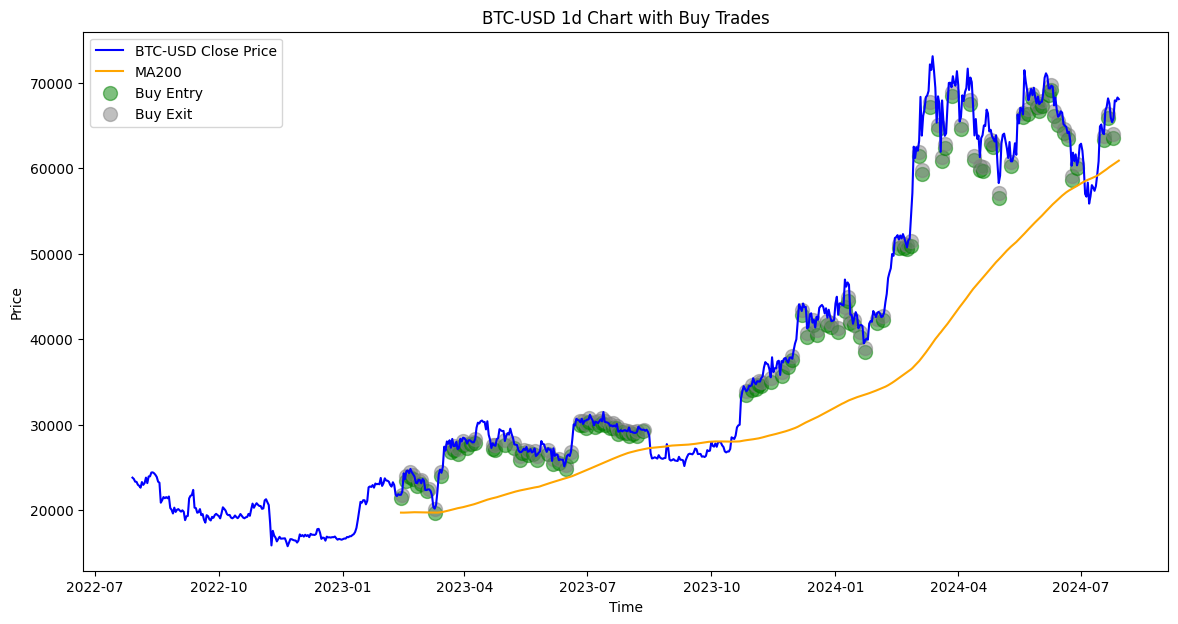

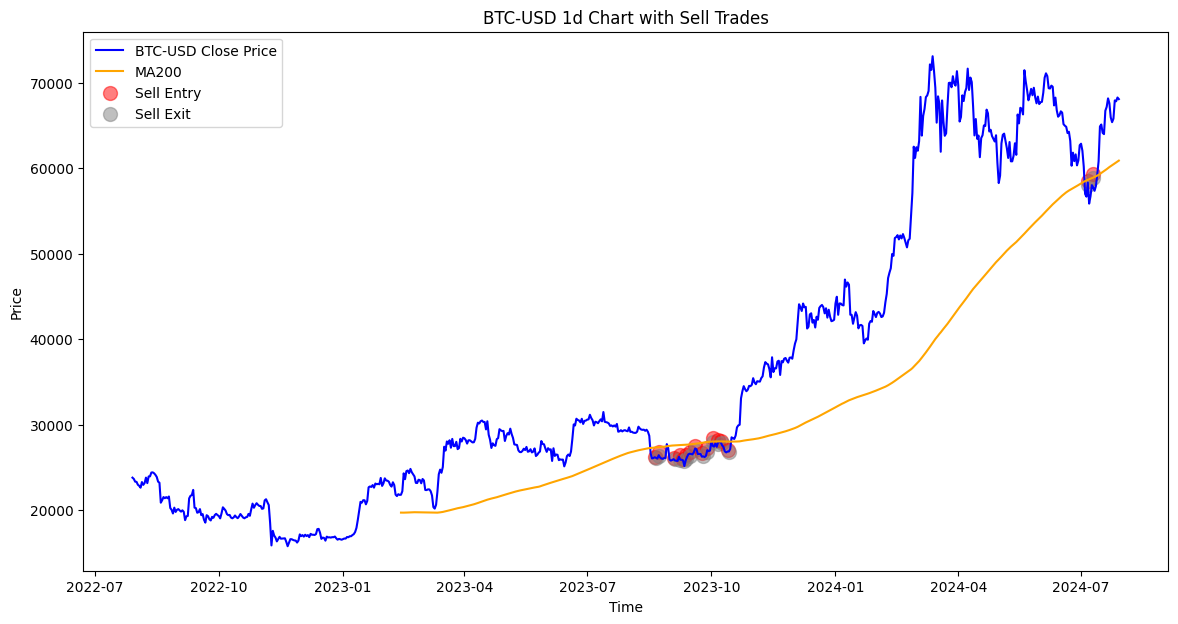

PnL for Buy Trades:
    Entry Date   Entry Price  Exit Date    Exit Price Result            PnL  \
0   2023-02-13  21460.087891 2023-02-14  21748.414062     SL   96108.723958   
1   2023-02-17  23460.755859 2023-02-17  23960.755859     TP  166666.666667   
2   2023-02-20  23927.910156 2023-02-20  24427.910156     TP  166666.666667   
3   2023-02-22  23644.318359 2023-02-22  24144.318359     TP  166666.666667   
4   2023-02-25  22861.558594 2023-02-26  23361.558594     TP  166666.666667   
..         ...           ...        ...           ...    ...            ...   
104 2024-06-24  58601.699219 2024-06-24  59101.699219     TP  166666.666667   
105 2024-06-28  59985.402344 2024-06-28  60485.402344     TP  166666.666667   
106 2024-07-18  63246.164062 2024-07-18  63746.164062     TP  166666.666667   
107 2024-07-21  65842.296875 2024-07-21  66342.296875     TP  166666.666667   
108 2024-07-25  63473.472656 2024-07-25  63973.472656     TP  166666.666667   

     Capital Before Trade  Posi

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Liste des unités de temps (ordonnée du plus petit au plus grand)
timeframes = ['1d']
period = '2y'
sl_pips = 150
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Paramètres de gestion de risque
capital = 10000
risk_per_trade = 500  # 5% de 10 000 USD
min_contract_size = 0.5
pip_value = 0.01  # Valeur d'un pip pour BTC-USD

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Calculer les moyennes mobiles pour déterminer la tendance primaire
data['MA200'] = data['Close'].rolling(window=200).mean()

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'buy': [], 'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints haussiers (niveau de support) et tendance haussière
        if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1] and data['Close'][i] > data['MA200'][i]:
            single_prints['buy'].append((data.index[i], data['Low'][i]))

        # Vérifier les single prints baissiers (niveau de résistance) et tendance baissière
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1] and data['Close'][i] < data['MA200'][i]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour calculer la taille de la position
def calculate_position_size(risk_per_trade, sl_pips, pip_value):
    return max(min_contract_size, risk_per_trade / (sl_pips * pip_value))

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, pip_value):
    trades = {'buy': [], 'sell': []}
    current_capital = capital

    for sp in single_prints['buy']:
        entry_date, entry_price = sp
        position_size = calculate_position_size(risk_per_trade, sl_pips, pip_value)
        sl_price = entry_price - sl_pips
        tp_price = entry_price + tp_pips
        highest_price = entry_price
        capital_before_trade = current_capital

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['Low'][i] <= sl_price:
                pnl = position_size * (sl_price - entry_price)
                current_capital += pnl
                trades['buy'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital_before_trade, position_size, current_capital))
                break
            if data['High'][i] >= tp_price:
                pnl = position_size * (tp_price - entry_price)
                current_capital += pnl
                trades['buy'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital_before_trade, position_size, current_capital))
                break

            # Mise à jour du trailing stop
            if data['High'][i] > highest_price:
                highest_price = data['High'][i]
                if highest_price - entry_price > trailing_threshold:
                    sl_price = highest_price - sl_pips

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        position_size = calculate_position_size(risk_per_trade, sl_pips, pip_value)
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price
        capital_before_trade = current_capital

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = position_size * (entry_price - sl_price)
                current_capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital_before_trade, position_size, current_capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * (entry_price - tp_price)
                current_capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital_before_trade, position_size, current_capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, pip_value)

# Afficher les trades et les graphiques
def plot_trades(data, trades, trade_type):
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')
    plt.plot(data['MA200'], label='MA200', color='orange')

    if trade_type == 'buy':
        color = 'green'
        label = 'Buy'
    else:
        color = 'red'
        label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before_trade, position_size, capital_after_trade = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

for trade_type in ['buy', 'sell']:
    plot_trades(data, trades, trade_type)

# Calculer et afficher la PnL et le winrate
def calculate_pnl_and_winrate(trades):
    pnl_buy = [trade[5] for trade in trades['buy']]
    pnl_sell = [trade[5] for trade in trades['sell']]
    total_pnl = pnl_buy + pnl_sell

    win_buy = sum(p > 0 for p in pnl_buy)
    win_sell = sum(p > 0 for p in pnl_sell)
    total_win = win_buy + win_sell

    winrate_buy = win_buy / len(pnl_buy) * 100 if pnl_buy else 0
    winrate_sell = win_sell / len(pnl_sell) * 100 if pnl_sell else 0
    total_winrate = total_win / len(total_pnl) * 100 if total_pnl else 0

    return pnl_buy, pnl_sell, total_pnl, winrate_buy, winrate_sell, total_winrate

pnl_buy, pnl_sell, total_pnl, winrate_buy, winrate_sell, total_winrate = calculate_pnl_and_winrate(trades)

# Afficher les PnL avec capital avant trade, bénéfice/perte et taille de position
def display_trades(trades, trade_type):
    trade_list = trades[trade_type]
    trade_df = pd.DataFrame(trade_list, columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
    return trade_df

pnl_df_buy = display_trades(trades, 'buy')
pnl_df_sell = display_trades(trades, 'sell')
pnl_df_total = pd.concat([pnl_df_buy, pnl_df_sell])

print('PnL for Buy Trades:')
print(pnl_df_buy)
print('Total PnL for Buy Trades:', pnl_df_buy['PnL'].sum())
print('Winrate for Buy Trades: {:.2f}%'.format(winrate_buy))

print('\nPnL for Sell Trades:')
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format(winrate_sell))

print('\nTotal PnL for All Trades:')
print(pnl_df_total)
print('Total PnL:', pnl_df_total['PnL'].sum())
print('Total Winrate: {:.2f}%'.format(total_winrate))

# Afficher les résultats en ajoutant les détails du capital et des positions
def display_trades_with_details(trades, trade_type):
    trade_list = trades[trade_type]
    trade_df = pd.DataFrame(trade_list, columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
    trade_df['Capital Before Trade'] = trade_df['Capital Before Trade'].round(2)
    trade_df['PnL'] = trade_df['PnL'].round(2)
    trade_df['Position Size'] = trade_df['Position Size'].round(2)
    trade_df['Capital After Trade'] = trade_df['Capital After Trade'].round(2)
    return trade_df

pnl_df_buy_with_details = display_trades_with_details(trades, 'buy')
pnl_df_sell_with_details = display_trades_with_details(trades, 'sell')
pnl_df_total_with_details = pd.concat([pnl_df_buy_with_details, pnl_df_sell_with_details])

print('\nDetailed PnL for Buy Trades:')
print(pnl_df_buy_with_details)
print('Total PnL for Buy Trades:', pnl_df_buy_with_details['PnL'].sum())
print('Winrate for Buy Trades: {:.2f}%'.format(winrate_buy))

print('\nDetailed PnL for Sell Trades:')
print(pnl_df_sell_with_details)
print('Total PnL for Sell Trades:', pnl_df_sell_with_details['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format(winrate_sell))

print('\nDetailed Total PnL for All Trades:')
print(pnl_df_total_with_details)
print('Total PnL:', pnl_df_total_with_details['PnL'].sum())
print('Total Winrate: {:.2f}%'.format(total_winrate))


[*********************100%%**********************]  1 of 1 completed


Buy trade: Entry on 2022-08-02 00:00:00 at 22710.083984375, Exit on 2022-08-02 00:00:00 at 23210.083984375 (TP), PnL: 220.16651296578655, Capital Before: 10000.0, Position Size: 0.4403330259315731, Capital After: 10220.166512965787
Buy trade: Entry on 2022-08-04 00:00:00 at 22485.701171875, Exit on 2022-08-04 00:00:00 at 22985.701171875 (TP), PnL: 227.25923543245162, Capital Before: 10220.166512965787, Position Size: 0.4545184708649032, Capital After: 10447.425748398238
Buy trade: Entry on 2022-08-07 00:00:00 at 22894.556640625, Exit on 2022-08-08 00:00:00 at 23209.009765625 (SL), PnL: -500, Capital Before: 10447.425748398238, Position Size: 0.456327934730997, Capital After: 9947.425748398238
Buy trade: Entry on 2022-08-10 00:00:00 at 22771.51953125, Exit on 2022-08-10 00:00:00 at 23271.51953125 (TP), PnL: 218.41813706694245, Capital Before: 9947.425748398238, Position Size: 0.43683627413388487, Capital After: 10165.843885465181
Buy trade: Entry on 2022-08-12 00:00:00 at 23657.265625, 

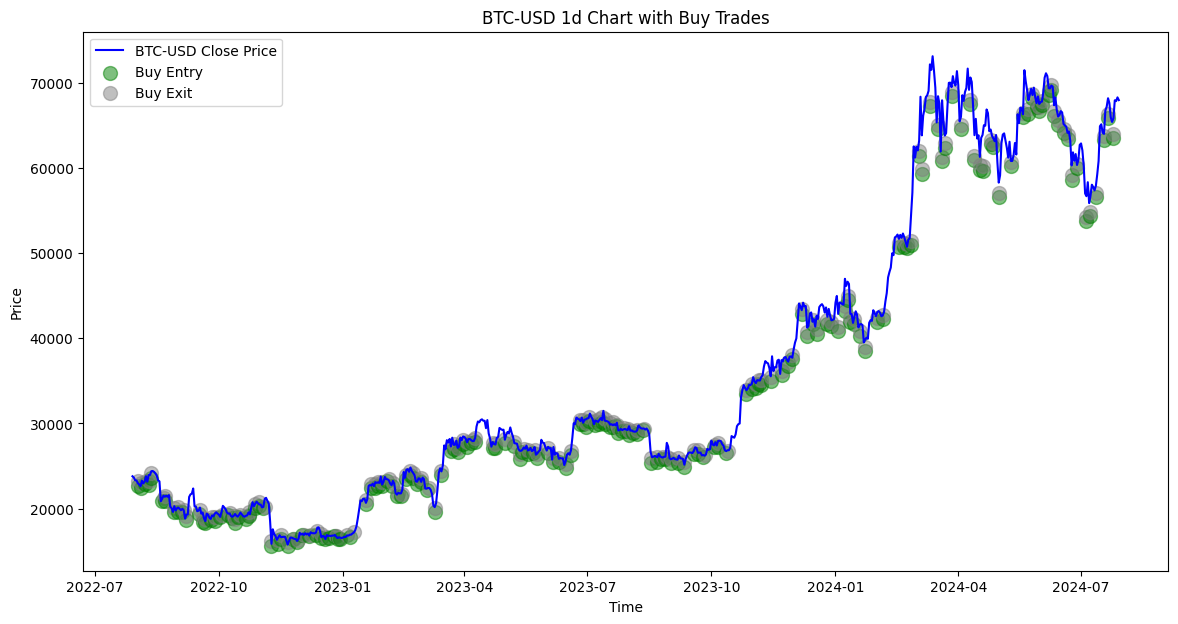

Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 285.22188903343175, Capital Before: 14017.27541661617, Position Size: 0.5704437780668635, Capital After: 14302.497305649602
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 303.2933833934862, Capital Before: 14302.497305649602, Position Size: 0.6065867667869723, Capital After: 14605.790689043088
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 311.785379013515, Capital Before: 14605.790689043086, Position Size: 0.62357075802703, Capital After: 14917.576068056602
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 308.1673993741181, Capital Before: 14917.576068056602, Position Size: 0.6163347987482362, Capital After: 15225.74346743072
Sell trade: Entry on 2022-08-11 00:00:

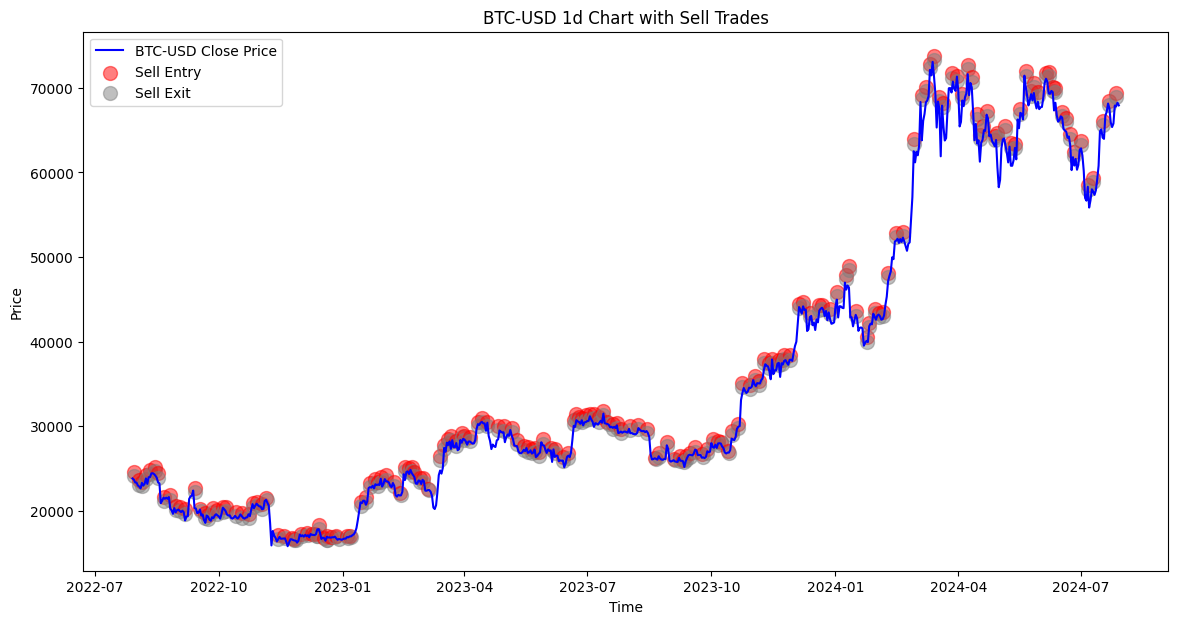


PnL for Buy Trades:
    Entry Date   Entry Price  Exit Date    Exit Price Result         PnL  \
0   2022-08-02  22710.083984 2022-08-02  23210.083984     TP  220.166513   
1   2022-08-04  22485.701172 2022-08-04  22985.701172     TP  227.259235   
2   2022-08-07  22894.556641 2022-08-08  23209.009766     SL -500.000000   
3   2022-08-10  22771.519531 2022-08-10  23271.519531     TP  218.418137   
4   2022-08-12  23657.265625 2022-08-12  24157.265625     TP  214.856697   
..         ...           ...        ...           ...    ...         ...   
170 2024-07-08  54321.019531 2024-07-08  54821.019531     TP  123.809253   
171 2024-07-12  56590.175781 2024-07-12  57090.175781     TP  119.938653   
172 2024-07-18  63246.164062 2024-07-18  63746.164062     TP  108.264570   
173 2024-07-21  65842.296875 2024-07-21  66342.296875     TP  104.817897   
174 2024-07-25  63473.472656 2024-07-25  63973.472656     TP  109.555374   

     Capital Before Trade  Position Size  Capital After Trade  
0 

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Liste des unités de temps (ordonnée du plus petit au plus grand)
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = 500
sl_pips = 150
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'buy': [], 'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints haussiers (niveau de support)
        if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1]:
            single_prints['buy'].append((data.index[i], data['Low'][i]))

        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'buy': [], 'sell': []}
    capital = initial_capital

    for sp in single_prints['buy']:
        entry_date, entry_price = sp
        sl_price = entry_price - sl_pips
        tp_price = entry_price + tp_pips
        highest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = min(max_risk_per_trade / sl_pips, capital / entry_price)

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['Low'][i] <= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['buy'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['High'][i] >= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['buy'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['High'][i] > highest_price:
                highest_price = data['High'][i]
                if highest_price - entry_price > trailing_threshold:
                    sl_price = highest_price - sl_pips

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = min(max_risk_per_trade / sl_pips, capital / entry_price)

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['buy', 'sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl}, Capital Before: {capital_before}, Position Size: {position_size}, Capital After: {capital_after}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    if trade_type == 'buy':
        color = 'green'
        label = 'Buy'
    else:
        color = 'red'
        label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['buy'] + trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Buy Trades:')
pnl_df_buy = pd.DataFrame(trades['buy'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
print(pnl_df_buy)
print('Total PnL for Buy Trades:', pnl_df_buy['PnL'].sum())
print('Winrate for Buy Trades: {:.2f}%'.format((pnl_df_buy['PnL'] > 0).mean() * 100))

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

print('\nTotal PnL for All Trades:')
pnl_df_total = pd.concat([pnl_df_buy, pnl_df_sell])
print(pnl_df_total)
print('Total PnL:', pnl_df_total['PnL'].sum())
print('Total Winrate: {:.2f}%'.format((pnl_df_total['PnL'] > 0).mean() * 100))


[*********************100%%**********************]  1 of 1 completed


Buy trade: Entry on 2022-08-02 00:00:00 at 22710.083984375, Exit on 2022-08-02 00:00:00 at 23210.083984375 (TP), PnL: 220.16651296578655, Capital Before: 10000.0, Position Size: 0.4403330259315731, Capital After: 10220.166512965787
Buy trade: Entry on 2022-08-04 00:00:00 at 22485.701171875, Exit on 2022-08-04 00:00:00 at 22985.701171875 (TP), PnL: 227.25923543245162, Capital Before: 10220.166512965787, Position Size: 0.4545184708649032, Capital After: 10447.425748398238
Buy trade: Entry on 2022-08-07 00:00:00 at 22894.556640625, Exit on 2022-08-08 00:00:00 at 23209.009765625 (SL), PnL: -500, Capital Before: 10447.425748398238, Position Size: 0.456327934730997, Capital After: 9947.425748398238
Buy trade: Entry on 2022-08-10 00:00:00 at 22771.51953125, Exit on 2022-08-10 00:00:00 at 23271.51953125 (TP), PnL: 218.41813706694245, Capital Before: 9947.425748398238, Position Size: 0.43683627413388487, Capital After: 10165.843885465181
Buy trade: Entry on 2022-08-12 00:00:00 at 23657.265625, 

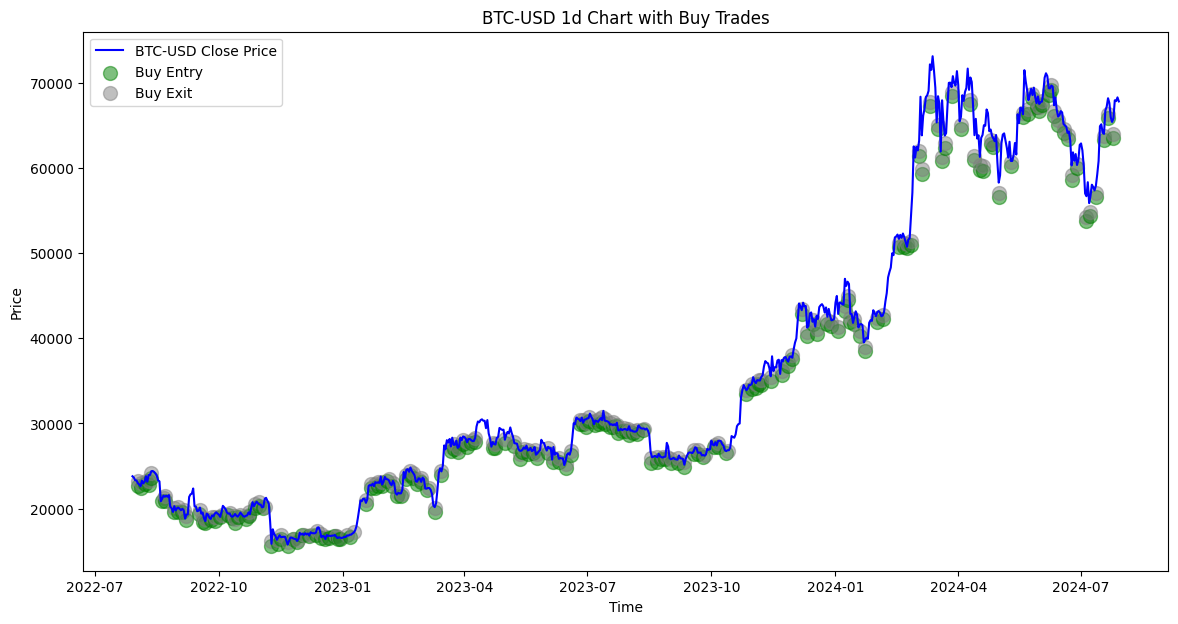

Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 203.47883633314922, Capital Before: 10000.0, Position Size: 0.40695767266629845, Capital After: 10203.47883633315
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 216.37113802726614, Capital Before: 10203.47883633315, Position Size: 0.4327422760545323, Capital After: 10419.849974360415
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 222.42937357421297, Capital Before: 10419.849974360415, Position Size: 0.44485874714842594, Capital After: 10642.279347934627
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 219.8482873560538, Capital Before: 10642.279347934627, Position Size: 0.4396965747121076, Capital After: 10862.12763529068
Sell trade: Entry on 2022-08-11 00:00:00 at

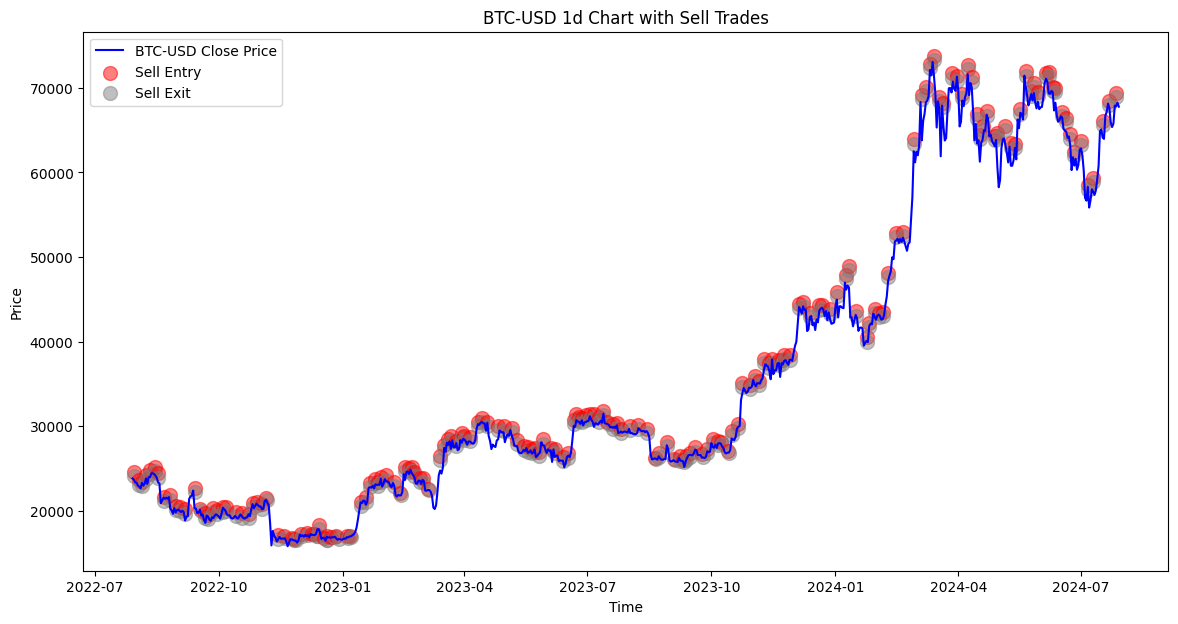


PnL for Buy Trades:
    Entry Date   Entry Price  Exit Date    Exit Price Result         PnL  \
0   2022-08-02  22710.083984 2022-08-02  23210.083984     TP  220.166513   
1   2022-08-04  22485.701172 2022-08-04  22985.701172     TP  227.259235   
2   2022-08-07  22894.556641 2022-08-08  23209.009766     SL -500.000000   
3   2022-08-10  22771.519531 2022-08-10  23271.519531     TP  218.418137   
4   2022-08-12  23657.265625 2022-08-12  24157.265625     TP  214.856697   
..         ...           ...        ...           ...    ...         ...   
170 2024-07-08  54321.019531 2024-07-08  54821.019531     TP  123.809253   
171 2024-07-12  56590.175781 2024-07-12  57090.175781     TP  119.938653   
172 2024-07-18  63246.164062 2024-07-18  63746.164062     TP  108.264570   
173 2024-07-21  65842.296875 2024-07-21  66342.296875     TP  104.817897   
174 2024-07-25  63473.472656 2024-07-25  63973.472656     TP  109.555374   

     Capital Before Trade  Position Size  Capital After Trade  
0 

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Liste des unités de temps (ordonnée du plus petit au plus grand)
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = 500
sl_pips = 150
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'buy': [], 'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints haussiers (niveau de support)
        if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1]:
            single_prints['buy'].append((data.index[i], data['Low'][i]))

        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'buy': [], 'sell': []}
    capital = initial_capital

    for sp in single_prints['buy']:
        entry_date, entry_price = sp
        sl_price = entry_price - sl_pips
        tp_price = entry_price + tp_pips
        highest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = min(max_risk_per_trade / sl_pips, capital / entry_price)

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['Low'][i] <= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['buy'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['High'][i] >= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['buy'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['High'][i] > highest_price:
                highest_price = data['High'][i]
                if highest_price - entry_price > trailing_threshold:
                    sl_price = highest_price - sl_pips

    capital = initial_capital  # Reset capital for sell trades

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = min(max_risk_per_trade / sl_pips, capital / entry_price)

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['buy', 'sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl}, Capital Before: {capital_before}, Position Size: {position_size}, Capital After: {capital_after}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'green' if trade_type == 'buy' else 'red'
    label = 'Buy' if trade_type == 'buy' else 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['buy'] + trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Buy Trades:')
pnl_df_buy = pd.DataFrame(trades['buy'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
print(pnl_df_buy)
print('Total PnL for Buy Trades:', pnl_df_buy['PnL'].sum())
print('Winrate for Buy Trades: {:.2f}%'.format((pnl_df_buy['PnL'] > 0).mean() * 100))

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

print('\nTotal PnL for All Trades:')
pnl_df_total = pd.concat([pnl_df_buy, pnl_df_sell])
print(pnl_df_total)
print('Total PnL:', pnl_df_total['PnL'].sum())
print('Total Winrate: {:.2f}%'.format((pnl_df_total['PnL'] > 0).mean() * 100))


[*********************100%%**********************]  1 of 1 completed


Buy trade: Entry on 2022-08-02 00:00:00 at 22710.083984375, Exit on 2022-08-02 00:00:00 at 23210.083984375 (TP), PnL: 220.16651296578655, Capital Before: 10000.0, Position Size: 0.4403330259315731, Capital After: 10220.166512965787
Buy trade: Entry on 2022-08-04 00:00:00 at 22485.701171875, Exit on 2022-08-04 00:00:00 at 22985.701171875 (TP), PnL: 227.25923543245162, Capital Before: 10220.166512965787, Position Size: 0.4545184708649032, Capital After: 10447.425748398238
Buy trade: Entry on 2022-08-07 00:00:00 at 22894.556640625, Exit on 2022-08-08 00:00:00 at 23209.009765625 (SL), PnL: -500, Capital Before: 10447.425748398238, Position Size: 0.456327934730997, Capital After: 9947.425748398238
Buy trade: Entry on 2022-08-10 00:00:00 at 22771.51953125, Exit on 2022-08-10 00:00:00 at 23271.51953125 (TP), PnL: 218.41813706694245, Capital Before: 9947.425748398238, Position Size: 0.43683627413388487, Capital After: 10165.843885465181
Buy trade: Entry on 2022-08-12 00:00:00 at 23657.265625, 

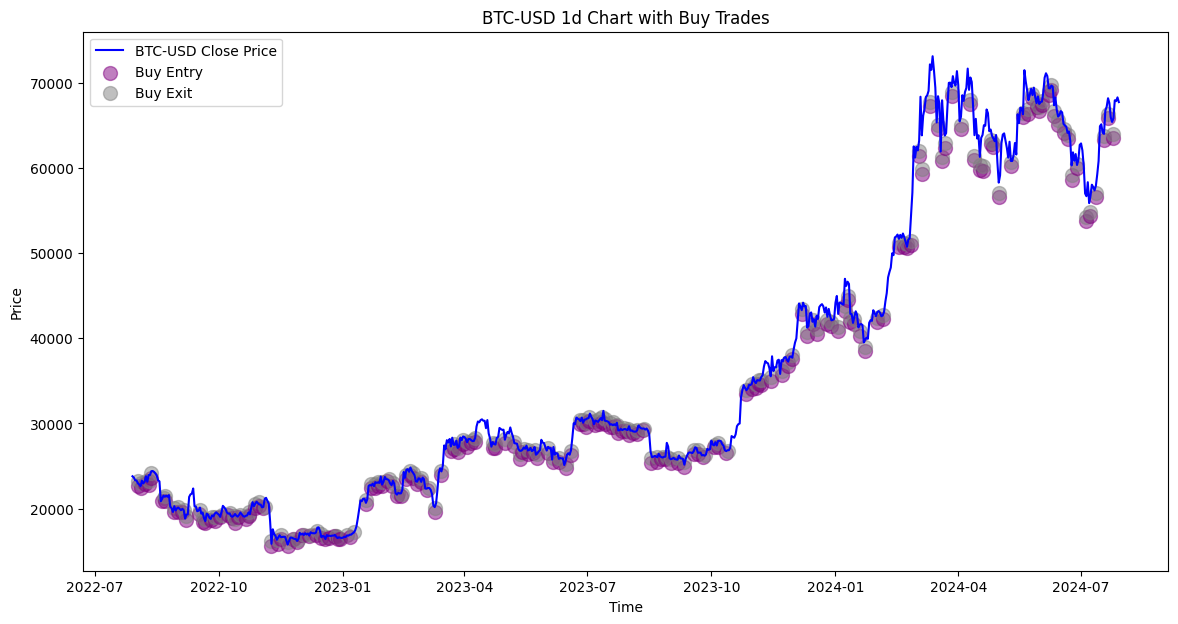

Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 203.47883633314922, Capital Before: 10000.0, Position Size: 0.40695767266629845, Capital After: 10203.47883633315
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 216.37113802726614, Capital Before: 10203.47883633315, Position Size: 0.4327422760545323, Capital After: 10419.849974360415
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 222.42937357421297, Capital Before: 10419.849974360415, Position Size: 0.44485874714842594, Capital After: 10642.279347934627
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 219.8482873560538, Capital Before: 10642.279347934627, Position Size: 0.4396965747121076, Capital After: 10862.12763529068
Sell trade: Entry on 2022-08-11 00:00:00 at

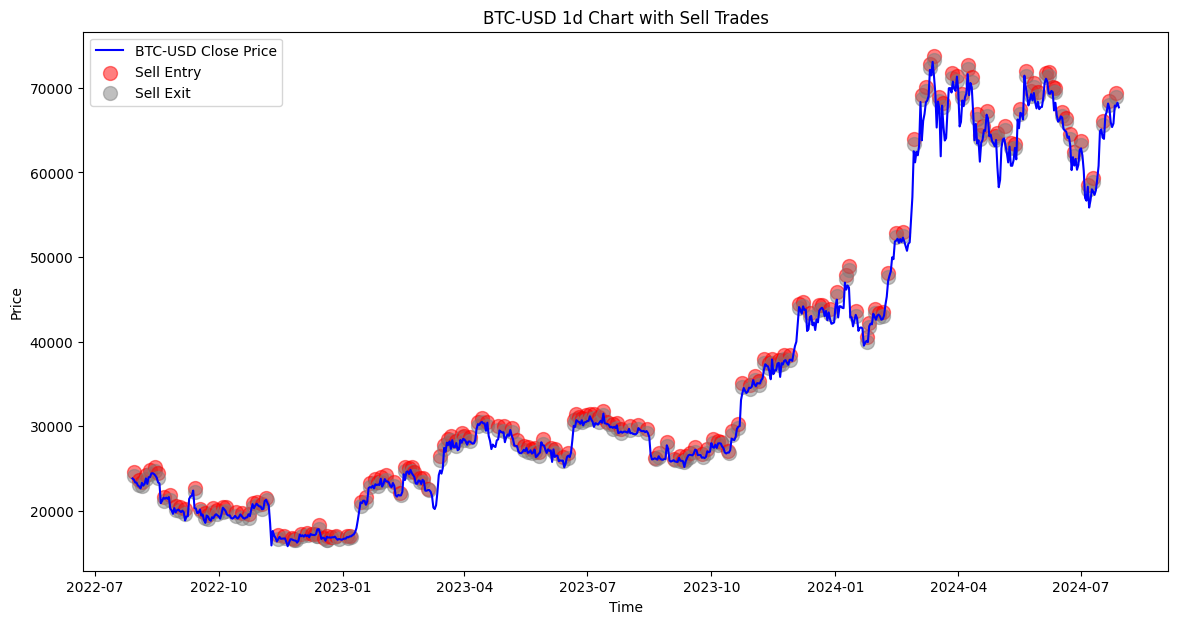


PnL for Buy Trades:
    Entry Date   Entry Price  Exit Date    Exit Price Result         PnL  \
0   2022-08-02  22710.083984 2022-08-02  23210.083984     TP  220.166513   
1   2022-08-04  22485.701172 2022-08-04  22985.701172     TP  227.259235   
2   2022-08-07  22894.556641 2022-08-08  23209.009766     SL -500.000000   
3   2022-08-10  22771.519531 2022-08-10  23271.519531     TP  218.418137   
4   2022-08-12  23657.265625 2022-08-12  24157.265625     TP  214.856697   
..         ...           ...        ...           ...    ...         ...   
170 2024-07-08  54321.019531 2024-07-08  54821.019531     TP  123.809253   
171 2024-07-12  56590.175781 2024-07-12  57090.175781     TP  119.938653   
172 2024-07-18  63246.164062 2024-07-18  63746.164062     TP  108.264570   
173 2024-07-21  65842.296875 2024-07-21  66342.296875     TP  104.817897   
174 2024-07-25  63473.472656 2024-07-25  63973.472656     TP  109.555374   

     Capital Before Trade  Position Size  Capital After Trade  
0 

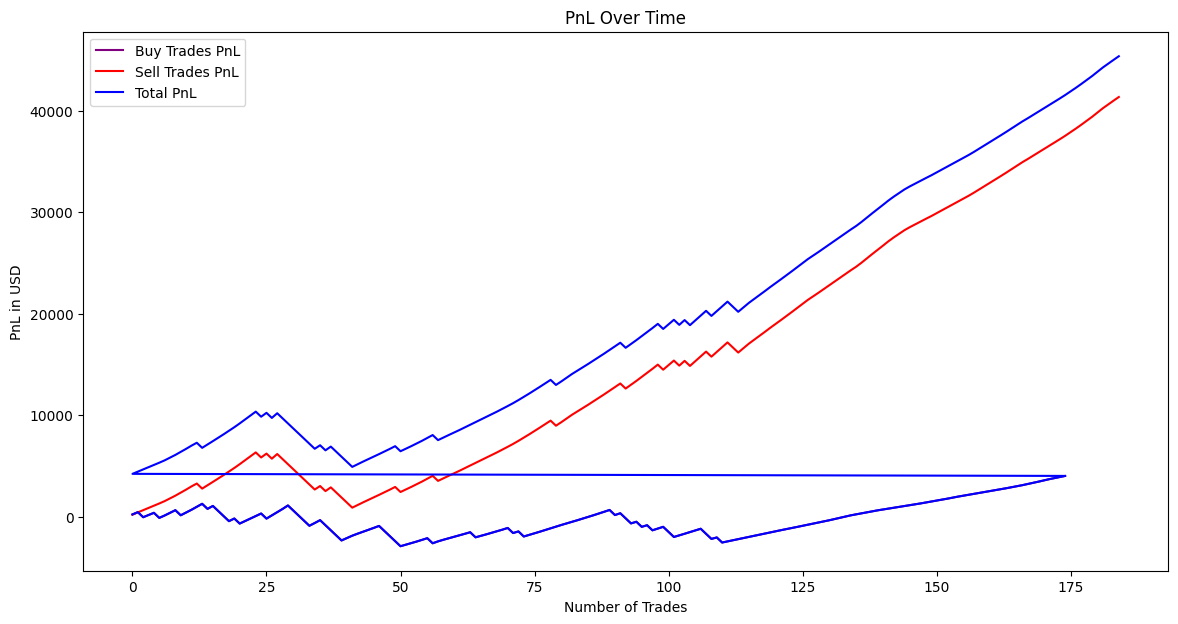

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Liste des unités de temps (ordonnée du plus petit au plus grand)
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = 500
sl_pips = 150
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'buy': [], 'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints haussiers (niveau de support)
        if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1]:
            single_prints['buy'].append((data.index[i], data['Low'][i]))

        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'buy': [], 'sell': []}
    capital = initial_capital

    for sp in single_prints['buy']:
        entry_date, entry_price = sp
        sl_price = entry_price - sl_pips
        tp_price = entry_price + tp_pips
        highest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = min(max_risk_per_trade / sl_pips, capital / entry_price)

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['Low'][i] <= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['buy'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['High'][i] >= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['buy'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['High'][i] > highest_price:
                highest_price = data['High'][i]
                if highest_price - entry_price > trailing_threshold:
                    sl_price = highest_price - sl_pips

    capital = initial_capital  # Reset capital for sell trades

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = min(max_risk_per_trade / sl_pips, capital / entry_price)

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['buy', 'sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl}, Capital Before: {capital_before}, Position Size: {position_size}, Capital After: {capital_after}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'purple' if trade_type == 'buy' else 'red'
    label = 'Buy' if trade_type == 'buy' else 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['buy'] + trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Buy Trades:')
pnl_df_buy = pd.DataFrame(trades['buy'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
print(pnl_df_buy)
print('Total PnL for Buy Trades:', pnl_df_buy['PnL'].sum())
print('Winrate for Buy Trades: {:.2f}%'.format((pnl_df_buy['PnL'] > 0).mean() * 100))

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

print('\nTotal PnL for All Trades:')
pnl_df_total = pd.concat([pnl_df_buy, pnl_df_sell])
print(pnl_df_total)
print('Total PnL for All Trades:', pnl_df_total['PnL'].sum())
print('Total Winrate for All Trades: {:.2f}%'.format((pnl_df_total['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_buy['PnL'].cumsum(), label='Buy Trades PnL', color='purple')
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.plot(pnl_df_total['PnL'].cumsum(), label='Total PnL', color='blue')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


10% de risque

[*********************100%%**********************]  1 of 1 completed


Buy trade: Entry on 2022-08-02 00:00:00 at 22710.083984375, Exit on 2022-08-02 00:00:00 at 23210.083984375 (TP), PnL: 220.16651296578655, Capital Before: 10000.0, Position Size: 0.4403330259315731, Capital After: 10220.166512965787
Buy trade: Entry on 2022-08-04 00:00:00 at 22485.701171875, Exit on 2022-08-04 00:00:00 at 22985.701171875 (TP), PnL: 227.25923543245162, Capital Before: 10220.166512965787, Position Size: 0.4545184708649032, Capital After: 10447.425748398238
Buy trade: Entry on 2022-08-07 00:00:00 at 22894.556640625, Exit on 2022-08-08 00:00:00 at 23209.009765625 (SL), PnL: -1000.0, Capital Before: 10447.425748398238, Position Size: 0.456327934730997, Capital After: 9447.425748398238
Buy trade: Entry on 2022-08-10 00:00:00 at 22771.51953125, Exit on 2022-08-10 00:00:00 at 23271.51953125 (TP), PnL: 207.4395109082042, Capital Before: 9447.425748398238, Position Size: 0.4148790218164084, Capital After: 9654.865259306442
Buy trade: Entry on 2022-08-12 00:00:00 at 23657.265625, 

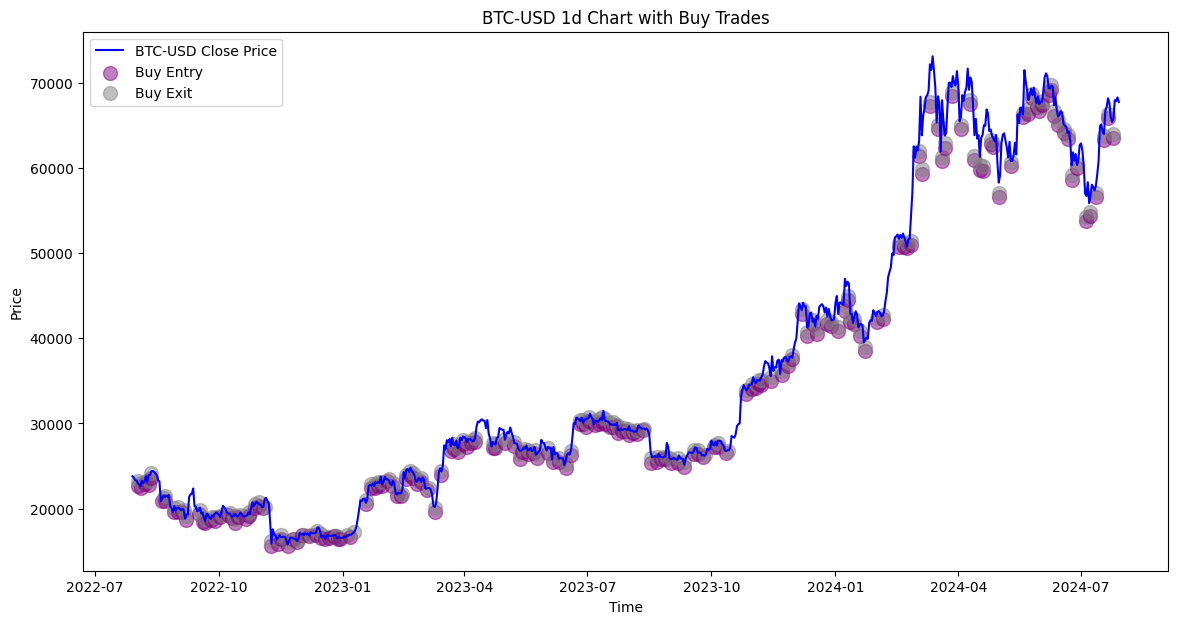

Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 203.47883633314922, Capital Before: 10000.0, Position Size: 0.40695767266629845, Capital After: 10203.47883633315
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 216.37113802726614, Capital Before: 10203.47883633315, Position Size: 0.4327422760545323, Capital After: 10419.849974360415
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 222.42937357421297, Capital Before: 10419.849974360415, Position Size: 0.44485874714842594, Capital After: 10642.279347934627
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 219.8482873560538, Capital Before: 10642.279347934627, Position Size: 0.4396965747121076, Capital After: 10862.12763529068
Sell trade: Entry on 2022-08-11 00:00:00 at

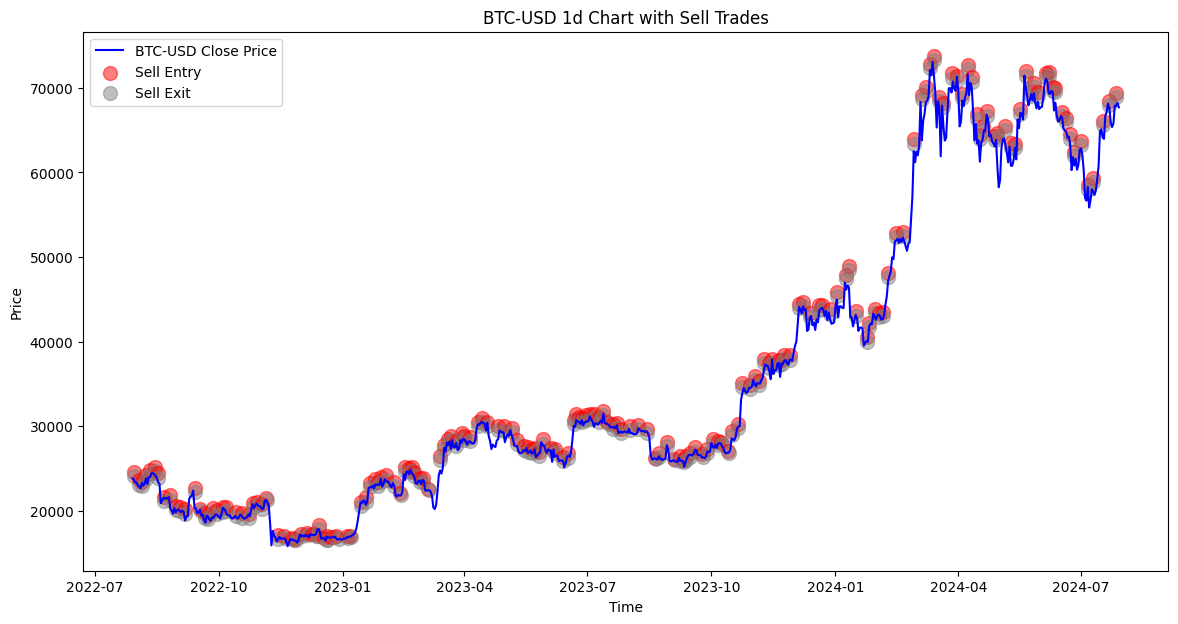


PnL for Buy Trades:
    Entry Date   Entry Price  Exit Date    Exit Price Result          PnL  \
0   2022-08-02  22710.083984 2022-08-02  23210.083984     TP   220.166513   
1   2022-08-04  22485.701172 2022-08-04  22985.701172     TP   227.259235   
2   2022-08-07  22894.556641 2022-08-08  23209.009766     SL -1000.000000   
3   2022-08-10  22771.519531 2022-08-10  23271.519531     TP   207.439511   
4   2022-08-12  23657.265625 2022-08-12  24157.265625     TP   204.057084   
..         ...           ...        ...           ...    ...          ...   
170 2024-07-08  54321.019531 2024-07-08  54821.019531     TP  -602.455385   
171 2024-07-12  56590.175781 2024-07-12  57090.175781     TP  -583.621061   
172 2024-07-18  63246.164062 2024-07-18  63746.164062     TP  -526.815016   
173 2024-07-21  65842.296875 2024-07-21  66342.296875     TP  -510.043514   
174 2024-07-25  63473.472656 2024-07-25  63973.472656     TP  -533.096060   

     Capital Before Trade  Position Size  Capital Afte

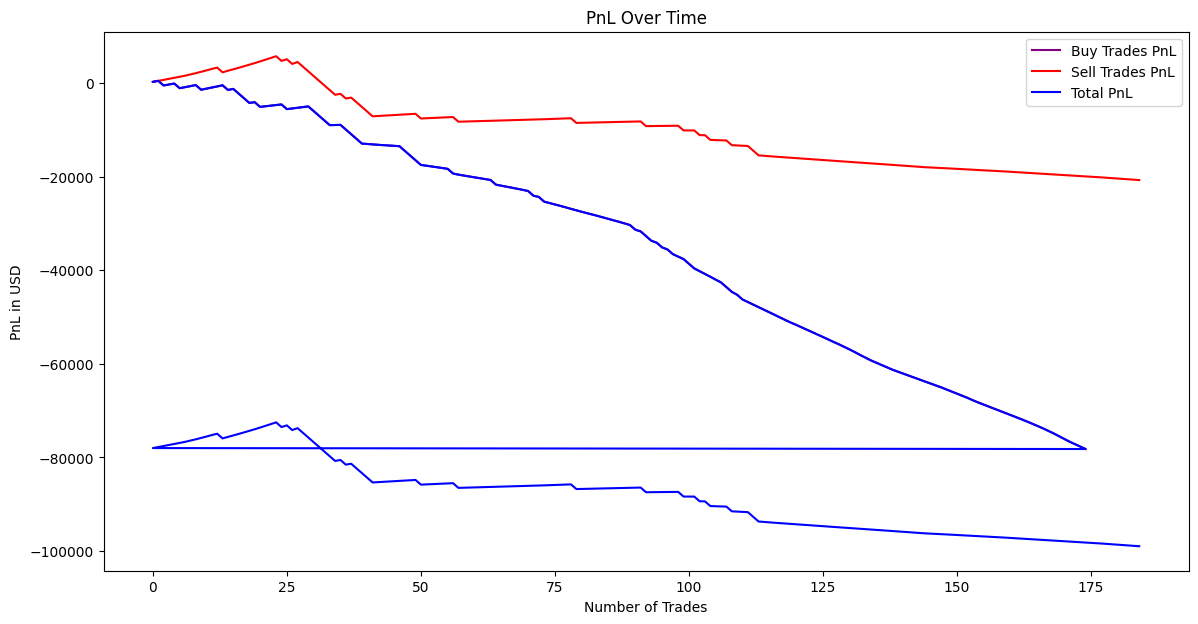

In [17]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 150
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'buy': [], 'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints haussiers (niveau de support)
        if data['Low'][i] < data['Low'][i-1] and data['Low'][i] < data['Low'][i+1]:
            single_prints['buy'].append((data.index[i], data['Low'][i]))

        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'buy': [], 'sell': []}
    capital = initial_capital

    for sp in single_prints['buy']:
        entry_date, entry_price = sp
        sl_price = entry_price - sl_pips
        tp_price = entry_price + tp_pips
        highest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = min(max_risk_per_trade / sl_pips, capital / entry_price)

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['Low'][i] <= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['buy'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['High'][i] >= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['buy'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['High'][i] > highest_price:
                highest_price = data['High'][i]
                if highest_price - entry_price > trailing_threshold:
                    sl_price = highest_price - sl_pips

    capital = initial_capital  # Reset capital for sell trades

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = min(max_risk_per_trade / sl_pips, capital / entry_price)

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['buy', 'sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl}, Capital Before: {capital_before}, Position Size: {position_size}, Capital After: {capital_after}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'purple' if trade_type == 'buy' else 'red'
    label = 'Buy' if trade_type == 'buy' else 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['buy'] + trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Buy Trades:')
pnl_df_buy = pd.DataFrame(trades['buy'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
print(pnl_df_buy)
print('Total PnL for Buy Trades:', pnl_df_buy['PnL'].sum())
print('Winrate for Buy Trades: {:.2f}%'.format((pnl_df_buy['PnL'] > 0).mean() * 100))

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

print('\nTotal PnL for All Trades:')
pnl_df_total = pd.concat([pnl_df_buy, pnl_df_sell])
print(pnl_df_total)
print('Total PnL for All Trades:', pnl_df_total['PnL'].sum())
print('Total Winrate for All Trades: {:.2f}%'.format((pnl_df_total['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_buy['PnL'].cumsum(), label='Buy Trades PnL', color='purple')
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.plot(pnl_df_total['PnL'].cumsum(), label='Total PnL', color='blue')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 6666.666666666667, Capital Before: 10000.0, Position Size: 13.333333333333334, Capital After: 16666.666666666668
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 6666.666666666667, Capital Before: 16666.666666666668, Position Size: 13.333333333333334, Capital After: 23333.333333333336
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 6666.666666666667, Capital Before: 23333.333333333336, Position Size: 13.333333333333334, Capital After: 30000.000000000004
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 6666.666666666667, Capital Before: 30000.000000000004, Position Size: 13.333333333333334, Capital After: 36666.66666666667
Sell trade: Entry on 2022-08-11 00:00:00 at 24

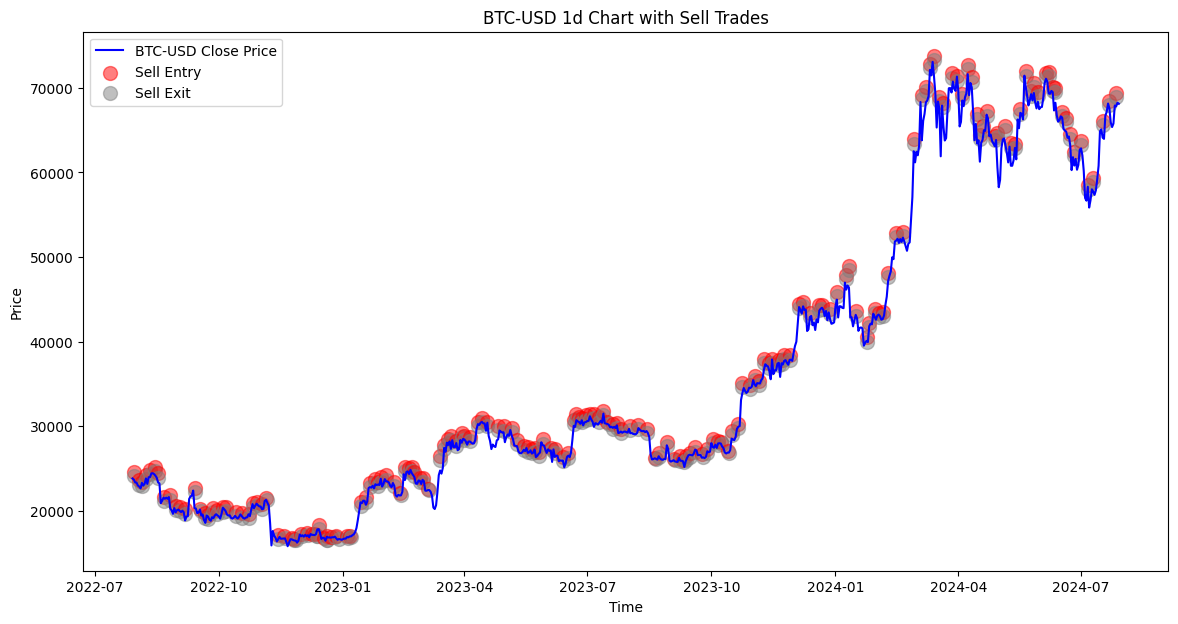


PnL for Sell Trades:
    Entry Date   Entry Price  Exit Date    Exit Price Result          PnL  \
0   2022-07-30  24572.580078 2022-07-30  24072.580078     TP  6666.666667   
1   2022-08-03  23578.650391 2022-08-03  23078.650391     TP  6666.666667   
2   2022-08-05  23422.828125 2022-08-05  22922.828125     TP  6666.666667   
3   2022-08-08  24203.689453 2022-08-08  23703.689453     TP  6666.666667   
4   2022-08-11  24822.628906 2022-08-11  24322.628906     TP  6666.666667   
..         ...           ...        ...           ...    ...          ...   
180 2024-07-06  58472.546875 2024-07-06  57972.546875     TP  6666.666667   
181 2024-07-10  59359.433594 2024-07-10  58859.433594     TP  6666.666667   
182 2024-07-17  66066.734375 2024-07-17  65566.734375     TP  6666.666667   
183 2024-07-22  68480.062500 2024-07-22  67980.062500     TP  6666.666667   
184 2024-07-27  69398.507812 2024-07-27  68898.507812     TP  6666.666667   

     Capital Before Trade  Position Size  Capital Aft

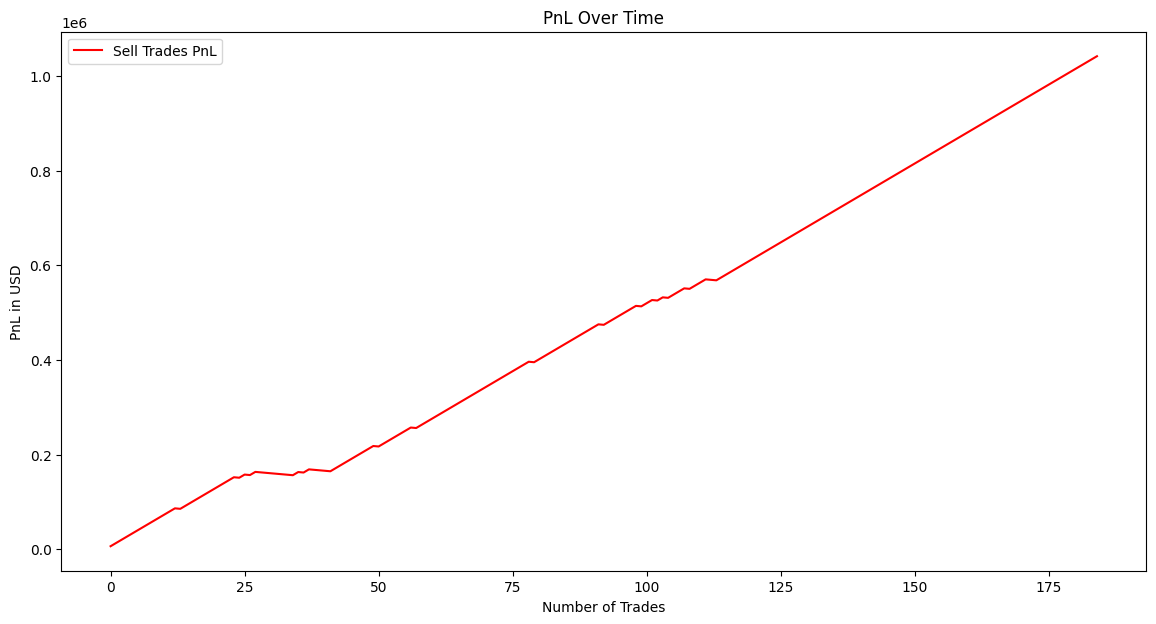

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 150
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl}, Capital Before: {capital_before}, Position Size: {position_size}, Capital After: {capital_after}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


Sell trade: Entry on 2022-07-30 00:00:00 at 24572.580078125, Exit on 2022-07-30 00:00:00 at 24072.580078125 (TP), PnL: 6666.67, Capital Before: 10000.00, Position Size: 13.33, Capital After: 16666.67
Sell trade: Entry on 2022-08-03 00:00:00 at 23578.650390625, Exit on 2022-08-03 00:00:00 at 23078.650390625 (TP), PnL: 6666.67, Capital Before: 16666.67, Position Size: 13.33, Capital After: 23333.33
Sell trade: Entry on 2022-08-05 00:00:00 at 23422.828125, Exit on 2022-08-05 00:00:00 at 22922.828125 (TP), PnL: 6666.67, Capital Before: 23333.33, Position Size: 13.33, Capital After: 30000.00
Sell trade: Entry on 2022-08-08 00:00:00 at 24203.689453125, Exit on 2022-08-08 00:00:00 at 23703.689453125 (TP), PnL: 6666.67, Capital Before: 30000.00, Position Size: 13.33, Capital After: 36666.67
Sell trade: Entry on 2022-08-11 00:00:00 at 24822.62890625, Exit on 2022-08-11 00:00:00 at 24322.62890625 (TP), PnL: 6666.67, Capital Before: 36666.67, Position Size: 13.33, Capital After: 43333.33
Sell tra

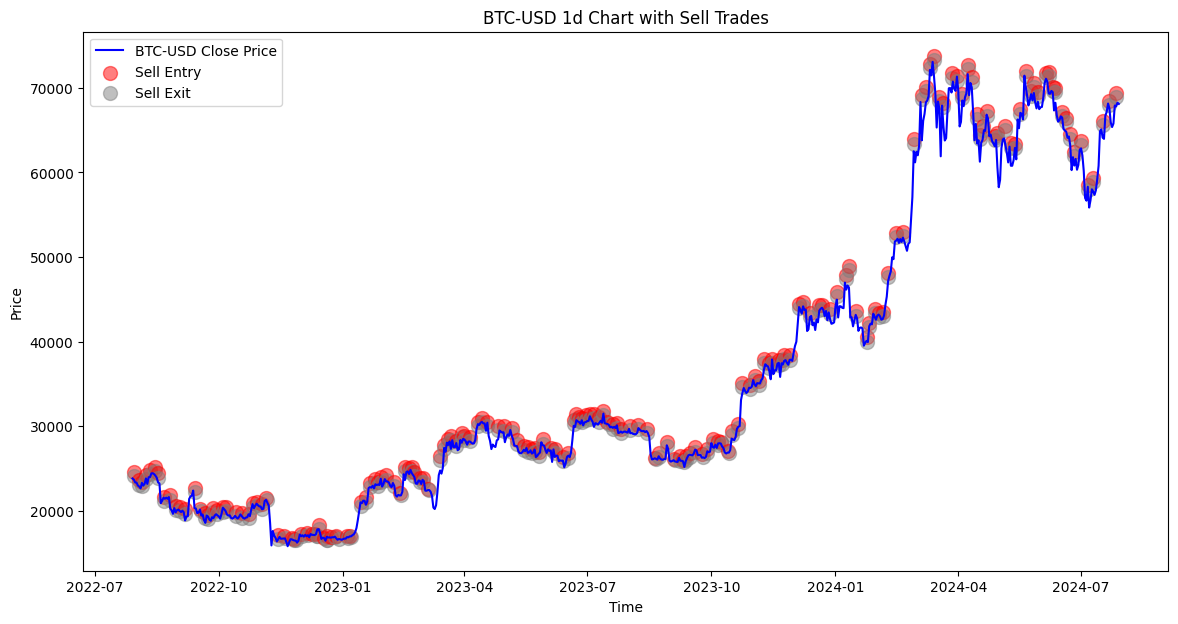


PnL for Sell Trades:
    Entry Date  Entry Price  Exit Date  Exit Price Result      PnL  \
0   2022-07-30     24572.58 2022-07-30    24072.58     TP  6666.67   
1   2022-08-03     23578.65 2022-08-03    23078.65     TP  6666.67   
2   2022-08-05     23422.83 2022-08-05    22922.83     TP  6666.67   
3   2022-08-08     24203.69 2022-08-08    23703.69     TP  6666.67   
4   2022-08-11     24822.63 2022-08-11    24322.63     TP  6666.67   
..         ...          ...        ...         ...    ...      ...   
180 2024-07-06     58472.55 2024-07-06    57972.55     TP  6666.67   
181 2024-07-10     59359.43 2024-07-10    58859.43     TP  6666.67   
182 2024-07-17     66066.73 2024-07-17    65566.73     TP  6666.67   
183 2024-07-22     68480.06 2024-07-22    67980.06     TP  6666.67   
184 2024-07-27     69398.51 2024-07-27    68898.51     TP  6666.67   

     Capital Before Trade  Position Size  Capital After Trade  
0                10000.00          13.33             16666.67  
1        

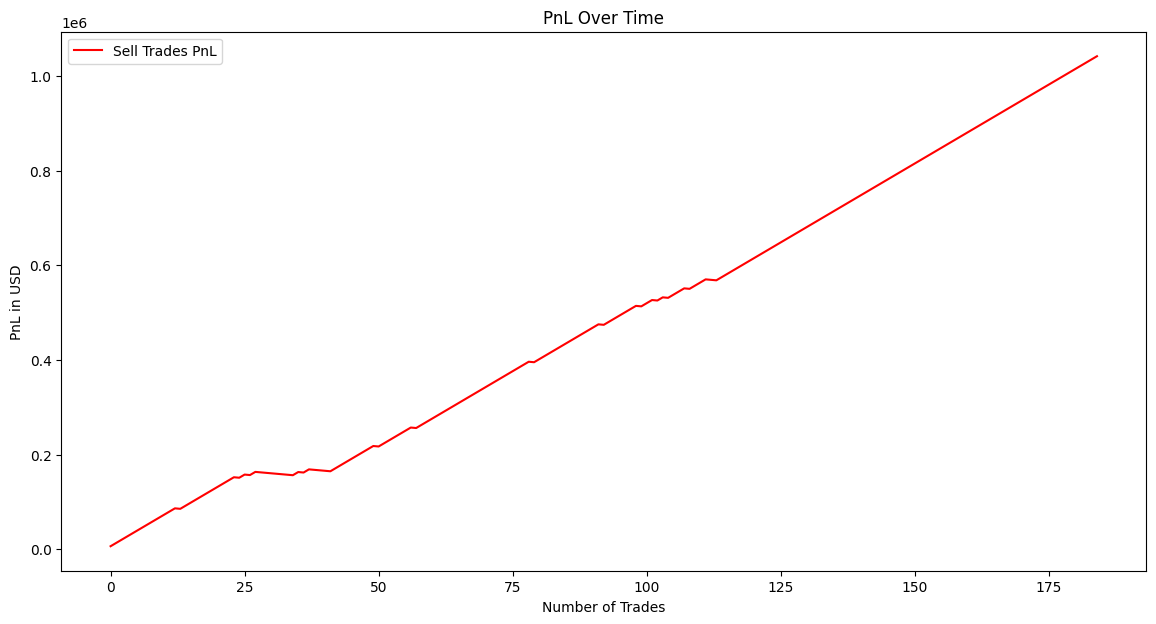

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Paramètres de trading
timeframes = ['1d']
period = '2y'
initial_capital = 10000
max_risk_per_trade = initial_capital * 0.10  # 10% de risque par trade soit 1000 USD
sl_pips = 150
tp_pips = 500
trailing_threshold = 1  # Trailing stop activé à partir de +1$

# Télécharger les données
data = yf.download('BTC-USD', period=period, interval=timeframes[0])

# Fonction pour détecter les single prints vierges
def detect_single_prints(data):
    single_prints = {'sell': []}

    for i in range(1, len(data) - 1):
        # Vérifier les single prints baissiers (niveau de résistance)
        if data['High'][i] > data['High'][i-1] and data['High'][i] > data['High'][i+1]:
            single_prints['sell'].append((data.index[i], data['High'][i]))

    return single_prints

# Détecter les single prints vierges
single_prints = detect_single_prints(data)

# Fonction pour appliquer les stop-loss, take-profit et trailing stop
def apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade):
    trades = {'sell': []}
    capital = initial_capital

    for sp in single_prints['sell']:
        entry_date, entry_price = sp
        sl_price = entry_price + sl_pips
        tp_price = entry_price - tp_pips
        lowest_price = entry_price

        # Calculer la taille de position basée sur le risque maximal par trade
        position_size = (max_risk_per_trade / sl_pips) * 2  # Doubler la taille de la position

        for i in range(data.index.get_loc(entry_date), len(data)):
            if data['High'][i] >= sl_price:
                pnl = -max_risk_per_trade
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], sl_price, 'SL', pnl, capital - pnl, position_size, capital))
                break
            if data['Low'][i] <= tp_price:
                pnl = position_size * tp_pips
                capital += pnl
                trades['sell'].append((entry_date, entry_price, data.index[i], tp_price, 'TP', pnl, capital - pnl, position_size, capital))
                break

            # Mise à jour du trailing stop
            if data['Low'][i] < lowest_price:
                lowest_price = data['Low'][i]
                if entry_price - lowest_price > trailing_threshold:
                    sl_price = lowest_price + sl_pips

    return trades

# Appliquer les stop-loss, take-profit et trailing stop
trades = apply_sl_tp(data, single_prints, sl_pips, tp_pips, trailing_threshold, initial_capital, max_risk_per_trade)

# Afficher les trades et les graphiques
for trade_type in ['sell']:
    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        print(f'{trade_type.capitalize()} trade: Entry on {entry_date} at {entry_price}, Exit on {exit_date} at {exit_price} ({result}), PnL: {pnl:.2f}, Capital Before: {capital_before:.2f}, Position Size: {position_size:.2f}, Capital After: {capital_after:.2f}')

    # Tracer le graphique
    plt.figure(figsize=(14, 7))
    plt.plot(data['Close'], label='BTC-USD Close Price', color='blue')

    color = 'red'
    label = 'Sell'

    for trade in trades[trade_type]:
        entry_date, entry_price, exit_date, exit_price, result, pnl, capital_before, position_size, capital_after = trade
        plt.scatter(entry_date, entry_price, color=color, s=100, alpha=0.5, label=f'{label} Entry' if trade == trades[trade_type][0] else "")
        plt.scatter(exit_date, exit_price, color='gray', s=100, alpha=0.5, label=f'{label} Exit' if trade == trades[trade_type][0] else "")

    plt.title(f'BTC-USD {timeframes[0]} Chart with {label} Trades')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Calculer et afficher la PnL
def calculate_pnl(trades):
    pnl = []
    for trade in trades['sell']:
        pnl.append(trade[5])
    return pnl

pnl = calculate_pnl(trades)
pnl_df = pd.DataFrame({'PnL': pnl})
total_pnl = pnl_df['PnL'].sum()
winrate = (pnl_df['PnL'] > 0).mean() * 100

print('\nPnL for Sell Trades:')
pnl_df_sell = pd.DataFrame(trades['sell'], columns=['Entry Date', 'Entry Price', 'Exit Date', 'Exit Price', 'Result', 'PnL', 'Capital Before Trade', 'Position Size', 'Capital After Trade'])
pnl_df_sell = pnl_df_sell.round(2)  # Arrondir les valeurs pour une meilleure lisibilité
print(pnl_df_sell)
print('Total PnL for Sell Trades:', pnl_df_sell['PnL'].sum())
print('Winrate for Sell Trades: {:.2f}%'.format((pnl_df_sell['PnL'] > 0).mean() * 100))

# Tracer les graphiques de la PnL
plt.figure(figsize=(14, 7))
plt.plot(pnl_df_sell['PnL'].cumsum(), label='Sell Trades PnL', color='red')
plt.title('PnL Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('PnL in USD')
plt.legend()
plt.show()
